## Step 1: importing necessary libraries 

1. tensorflow (main DL library) 
2. pandas and numpy (data tools)
3. sklearn.metrics, seaborn, maptplotlib (visualization tools)
4. other tools

In [1]:


import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd
import time
import os
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications import ResNet50, DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import ResNet50, DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.image import resize



2024-09-18 12:52:12.747300: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
/home/hice1/spadmanabha3/.conda/envs/test_gpu/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Step 2: Check for GPU


In [2]:
#Check GPU and suppress warnings
print(tf.config.list_physical_devices('GPU'))
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())
print(tf.__version__)

warnings.filterwarnings('ignore', category=FutureWarning)

2024-09-18 12:52:17.398572: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-09-18 12:52:17.399718: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-09-18 12:52:17.460161: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.73GiB deviceMemoryBandwidth: 836.37GiB/s
2024-09-18 12:52:17.460191: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-09-18 12:52:17.463334: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-09-18 12:52:17.463399: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
['/device:CPU:0', '/device:GPU:0']
2.4.1


2024-09-18 12:52:17.478696: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-18 12:52:17.478809: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-09-18 12:52:17.479105: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.73GiB deviceMemoryBandwidth: 836.37GiB/s
2024-09-18 12:52:17.479128: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-09-18 12:52:17.479151: I tensorflow/stream_executor/platfor

## Step 3: Function to Load the MNIST Dataset

The function can load any number of images, say 1000, 3000, 6000, or 'all'.

In [3]:
def load_data(dataset_size='all'):
    (train_images, train_labels), (test_images, test_labels) = mnist.load_data()
    
    # Combine train and test datasets for easier splitting
    all_images = np.concatenate([train_images, test_images], axis=0)
    all_labels = np.concatenate([train_labels, test_labels], axis=0)
    
    # Reshape and normalize the images
    all_images = all_images.reshape((all_images.shape[0], 28, 28, 1)).astype('float32') / 255
    
    # Convert labels to one-hot encoding
    all_labels = to_categorical(all_labels)
    
    if dataset_size == 'all':
        selected_images = all_images
        selected_labels = all_labels
    else:
        if not isinstance(dataset_size, int) or dataset_size <= 0:
            raise ValueError("dataset_size must be a positive integer or 'all'.")
        
        samples_per_class = dataset_size // 10
        selected_indices = []
        for i in range(10):
            class_indices = np.where(all_labels[:, i] == 1)[0]
            if len(class_indices) < samples_per_class:
                raise ValueError(f"Not enough samples for class {i} to meet the dataset_size requirement.")
            selected_indices.extend(class_indices[:samples_per_class])
        
        selected_images = all_images[selected_indices]
        selected_labels = all_labels[selected_indices]
    
    # Split the selected samples into train, validation, and test sets (60-20-20)
    train_images, test_images, train_labels, test_labels = train_test_split(
        selected_images, selected_labels, test_size=0.4, random_state=42
    )
    test_images, val_images, test_labels, val_labels = train_test_split(
        test_images, test_labels, test_size=0.5, random_state=42
    )
    
    return train_images, train_labels, val_images, val_labels, test_images, test_labels

## Step 4: Function for exploratory data analysis

We perform exploratory data analysis for the train, test and validation datasets, we print the dataset distribution and print image statistics

#Reference https://www.kaggle.com/code/pavansanagapati/3-layer-convolutional-neural-network-cnn

In [4]:
# Exploratory Data Analysis (EDA)
def perform_eda(train_images, train_labels, val_images, val_labels, test_images, test_labels):
    # Data distribution across classes for train, validation, and test sets
    def plot_data_distribution(labels, dataset_name):
        class_counts = np.sum(labels, axis=0)  # Sum across one-hot encoded labels
        plt.figure(figsize=(10, 6))
        sns.barplot(x=np.arange(10), y=class_counts)
        plt.title(f'Data Distribution for {dataset_name} Set')
        plt.xlabel('Class')
        plt.ylabel('Number of Images')
        plt.show()

    def calculate_metrics(images, labels, dataset_name):
        num_images = images.shape[0]
        num_classes = labels.shape[1]
        class_counts = np.sum(labels, axis=0)
        total_size = num_images * images.shape[1] * images.shape[2] * images.shape[3]  # Total pixel count
        avg_image_size = total_size / num_images
        image_size_bytes = images.nbytes  # Size in bytes
        img_height, img_width = images.shape[1], images.shape[2]

        print(f"\n{dataset_name} Set Metrics:")
        print(f"Total Number of Images: {num_images}")
        print(f"Number of Images per Class: {dict(enumerate(class_counts))}")
        print(f"Total Image Size (in pixels): {total_size}")
        print(f"Average Image Size (in pixels): {avg_image_size:.2f}")
        print(f"Total Size of Images (in bytes): {image_size_bytes / (1024 * 1024):.2f} MB")
        print(f"Image Resolution (Height x Width): {img_height} x {img_width}")

    print("Train Set Data Distribution:")
    plot_data_distribution(train_labels, 'Train')

    print("Validation Set Data Distribution:")
    plot_data_distribution(val_labels, 'Validation')

    print("Test Set Data Distribution:")
    plot_data_distribution(test_labels, 'Test')

    # Visualizing 5 images per class for the train, validation, and test sets
    def plot_images_per_class(images, labels, dataset_name):
        fig, axes = plt.subplots(10, 5, figsize=(15, 20))
        fig.suptitle(f'{dataset_name} Set: 5 Images Per Class', fontsize=16)
        for i in range(10):
            idxs = np.where(labels.argmax(axis=1) == i)[0][:5]
            for j, idx in enumerate(idxs):
                axes[i, j].imshow(images[idx].reshape(images.shape[1], images.shape[2]), cmap='gray')
                axes[i, j].axis('off')
        plt.show()

    print("Train Set: 5 Images Per Class")
    plot_images_per_class(train_images, train_labels, 'Train')

    print("Validation Set: 5 Images Per Class")
    plot_images_per_class(val_images, val_labels, 'Validation')

    print("Test Set: 5 Images Per Class")
    plot_images_per_class(test_images, test_labels, 'Test')

    # Calculate and print metrics
    calculate_metrics(train_images, train_labels, 'Train')
    calculate_metrics(val_images, val_labels, 'Validation')
    calculate_metrics(test_images, test_labels, 'Test')

## Step 5: CNN3 Model 

We create an auxillary function to create a CNN model with 3 Conv2D layers and provide option to change the hyperparameters.

#Reference : https://medium.com/@BrendanArtley/mnist-keras-simple-cnn-99-6-731b624aee7f
#Reference : https://www.kaggle.com/code/pavansanagapati/3-layer-convolutional-neural-network-cnn
#Reference : https://www.tensorflow.org/tutorials/images/cnn

In [5]:
# Function to create CNN model
def create_model(optimizer='adam', learning_rate=0.001, num_filters=[32, 64, 128], feature_map_size=3, dropout_rate=0.25):
    # Configure optimizer with learning rate
    if optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError("Unsupported optimizer")


    #Note to self : without padding, it will give error for [5,5] kernel!
    model = models.Sequential([
        layers.Conv2D(num_filters[0], (feature_map_size, feature_map_size), activation='relu', input_shape=(28, 28, 1), padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(num_filters[1], (feature_map_size, feature_map_size), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(num_filters[2], (feature_map_size, feature_map_size), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

## Step 6: Auxillary functions for training models

To maintain readablity, reusability and modularity, we define auxillary functions 

In [6]:
# Function to train and evaluate the model
def train_model(model, train_images, train_labels, val_images, val_labels, batch_size=128, epochs=10):
    start_time = time.time()  # Start timer for training time
    history = model.fit(train_images, train_labels, epochs=epochs, 
                        batch_size=batch_size, validation_data=(val_images, val_labels))
    train_time = time.time() - start_time  # Calculate training time
    return history, train_time

# Function to evaluate the model and compute test time
def evaluate_model(model, test_images, test_labels):
    start_time = time.time()  # Start timer for test time
    test_loss, test_accuracy = model.evaluate(test_images, test_labels)
    test_time = time.time() - start_time  # Calculate test time
    return test_accuracy, test_time

# Function to save a model
def save_model(model, model_name='saved_model.h5'):
    model.save(model_name)
    print(f"Model saved to {model_name}")

# Function to load a model
def load_model(model_name='saved_model.h5'):
    if not os.path.exists(model_name):
        raise FileNotFoundError(f"No model file found at {model_name}")
    model = tf.keras.models.load_model(model_name)
    print(f"Model loaded from {model_name}")
    return model

# Function to calculate model size in MB
def calculate_model_size(model):
    temp_file = 'temp_model.h5'
    save_model(model, temp_file)  # Save model to temporary file
    model_size = os.path.getsize(temp_file) / (1024 * 1024)  # Get size in MB
    os.remove(temp_file)  # Clean up the temporary file
    return model_size

# Function to make predictions with a model
def predict_with_model(model, data):
    predictions = model.predict(data)
    return predictions

# Function to plot the confusion matrix
def plot_confusion_matrix(test_labels, predictions, class_names):
    cm = confusion_matrix(test_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
# Function to plot training/validation accuracy and loss vs epochs
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

## Step 6: Auxillary function to calculate results

We write a function that creates models based on configurations passed and evaluates it. It also results the results dataframe for analysis.

In [7]:
def collect_results(configurations, train_images, train_labels, val_images, val_labels, test_images, test_labels):
    results = []
    
    for i, config in enumerate(configurations):
        print(f"Training model {i + 1} with configuration: {config['description']}")
        
        model = create_model(optimizer=config['optimizer'], 
                             learning_rate=config['learning_rate'], 
                             num_filters=config['num_filters'], 
                             feature_map_size=config['feature_map_size'], 
                             dropout_rate=config['dropout_rate'])
                             
        history, train_time = train_model(model, train_images, train_labels, val_images, val_labels, 
                                          batch_size=config['batch_size'], epochs=config['epochs'])
                                          
        test_accuracy, test_time = evaluate_model(model, test_images, test_labels)
        model_size = calculate_model_size(model)
        save_model(model, f'Model_{i}.h5')
        
        results.append({
            'Model': i + 1,
            'Description': config['description'],
            'Training Time (s)': train_time,
            'Training Accuracy (%)': history.history['accuracy'][-1] * 100,
            'Validation Accuracy (%)': history.history['val_accuracy'][-1] * 100,
            'Testing Time (s)': test_time,
            'Testing Accuracy (%)': test_accuracy * 100,
            'Model Size (MB)': model_size
        })
        
        predictions = model.predict(test_images).argmax(axis=1)
        test_labels_class = test_labels.argmax(axis=1)
        plot_confusion_matrix(test_labels_class, predictions, [str(i) for i in range(10)])
        plot_training_history(history)
    
    # Convert results to DataFrame
    df_results = pd.DataFrame(results)
    return df_results

## Step 7: More Auxillary functions

1. compare_with_baseline will generate a table to compare the baseline model with other models
2. visualize_predictions and visualize_all_models will predict images using test dataset and visualize neatly


In [8]:
#To print neatly in jupyter, I used Jinja2 
#Reference : https://anaconda.org/anaconda/jinja2 
#Reference : https://gist.github.com/tonyfast/84f13b1460cb8fcbc43a

def compare_with_baseline(df_results):
    # Check if the baseline is present in the results
    if 'Baseline model' not in df_results['Description'].values:
        raise ValueError("Baseline model is not found in the results. Ensure the baseline model is included in the DataFrame.")
    
    # Extract the baseline results
    baseline = df_results[df_results['Description'] == 'Baseline model'].iloc[0]
    
    # Initialize a list to hold comparison results
    comparison_results = []

    # Add baseline model results
    comparison_results.append({
        'Model': 'Baseline model',
        'Training Time (s)': baseline['Training Time (s)'],
        'Training Accuracy (%)': baseline['Training Accuracy (%)'],
        'Validation Accuracy (%)': baseline['Validation Accuracy (%)'],
        'Testing Time (s)': baseline['Testing Time (s)'],
        'Testing Accuracy (%)': baseline['Testing Accuracy (%)'],
        'Model Size (MB)': baseline['Model Size (MB)']
    })
    
    # Compare baseline model with each model individually
    for _, row in df_results.iterrows():
        if row['Description'] != 'Baseline model':
            comparison_results.append({
                'Model': row['Description'],
                'Training Time (s)': row['Training Time (s)'],
                'Training Accuracy (%)': row['Training Accuracy (%)'],
                'Validation Accuracy (%)': row['Validation Accuracy (%)'],
                'Testing Time (s)': row['Testing Time (s)'],
                'Testing Accuracy (%)': row['Testing Accuracy (%)'],
                'Model Size (MB)': row['Model Size (MB)']
            })
    
    # Convert comparison results to DataFrame
    df_comparison = pd.DataFrame(comparison_results)
    
    # Add an index column starting from 1
    df_comparison.index += 1
    df_comparison.index.name = 'Comparison Number'
    
    # Style the DataFrame for better readability in Jupyter notebooks
    styled_df = df_comparison.style \
        .format({'Training Time (s)': '{:.2f}', 
                 'Training Accuracy (%)': '{:.2f}', 
                 'Validation Accuracy (%)': '{:.2f}', 
                 'Testing Time (s)': '{:.2f}', 
                 'Testing Accuracy (%)': '{:.2f}', 
                 'Model Size (MB)': '{:.2f}'}) \
        .set_caption('Comparison of Each Model with the Baseline Model') \
        .set_table_styles([{'selector': 'thead', 
                            'props': [('background-color', '#f5f5f5'), 
                                      ('font-weight', 'bold')]}]) \
        .hide(axis='index')

    return styled_df

In [9]:
def visualize_predictions(model, test_images, test_labels, num_samples=5):
    # Predict classes for the test images
    predictions = model.predict(test_images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(test_labels, axis=1)
    
    # Randomly select indices for visualization
    indices = np.random.choice(len(test_images), num_samples, replace=False)
    
    plt.figure(figsize=(12, 12))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(test_images[idx].reshape(28, 28), cmap='gray')
        plt.title(f"True: {true_classes[idx]}\nPred: {predicted_classes[idx]}")
        plt.axis('off')
    plt.show()
    
def visualize_all_models(models_range, test_images, test_labels, num_samples=10):
    for i in models_range:
        # Load the model
        model_filename = f'Model_{i}.h5'
        try:
            loaded_model = load_model(model_filename)
            print(f"Visualizing predictions for {model_filename}...")
            # Visualize predictions
            visualize_predictions(loaded_model, test_images, test_labels, num_samples=num_samples)
            visualize_predictions(loaded_model, test_images, test_labels, num_samples=num_samples)
        except Exception as e:
            print(f"Failed to load or visualize {model_filename}. Error: {e}")

## Step 8: Outlier Testing Auxillary Functions

To test the outliers, I have written some auxillary functions that predict on models generated in earlier steps.

In [10]:
# 1. Define a list of outlier image file paths
outlier_file_paths = [
    'outliers/outlier1.jpg', 'outliers/outlier2.jpg', 'outliers/outlier3.jpg', 'outliers/outlier4.jpg', 'outliers/outlier5.jpg',
    'outliers/outlier6.jpg', 'outliers/outlier7.jpg', 'outliers/outlier8.jpg', 'outliers/outlier9.jpg', 'outliers/outlier10.jpg'
]

outlier_labels = ['a', 'b', 'zeta', 'm','e', '6_tilt','g', 'z', 'p', 'Oo']  # List of actual labels for outlier images

# 5. Visualize outlier examples
def visualize_outlier_examples(file_paths, num_examples=5):
    fig, axes = plt.subplots(1, num_examples, figsize=(15, 5))
    for ax, file_path in zip(axes, file_paths[:num_examples]):
        img = image.load_img(file_path, target_size=(28, 28), color_mode='grayscale')
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    plt.show()
    
def visualize_outliers(models, outlier_images, outlier_labels, num_samples=10):
    """
    Visualize predictions for outlier images using a list of models.

    Parameters:
    - models: List of trained models
    - outlier_images: List of file paths to outlier images
    - outlier_labels: List of true labels for outlier images
    - num_samples: Number of samples to visualize
    """
    num_models = len(models)
    num_samples = min(num_samples, len(outlier_images))
    results = []

    for i, model in enumerate(models):
        print(f"Model {i}:")
        fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 5))
        fig.suptitle(f'Model {i} Predictions on Outliers', fontsize=16)

        for j in range(num_samples):
            img = load_img(outlier_images[j], target_size=(28, 28), color_mode='grayscale')
            img_array = img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)

            # Predict
            prediction = model.predict(img_array)
            predicted_class = np.argmax(prediction)
            predicted_prob = prediction[0]

            # Display image
            axes[j, 0].imshow(img_array[0, :, :, 0], cmap='gray')
            axes[j, 0].set_title(f'Image {j + 1}')
            axes[j, 0].axis('off')

            # Display actual and predicted class
            axes[j, 1].text(0.5, 0.5, f'Actual: {outlier_labels[j]}', fontsize=12, ha='center')
            axes[j, 1].text(0.5, 0.3, f'Predicted: {predicted_class}', fontsize=12, ha='center')
            axes[j, 1].axis('off')

            # Display prediction probabilities
            axes[j, 2].bar(range(10), predicted_prob)
            axes[j, 2].set_title('Probabilities')
            axes[j, 2].set_xticks(range(10))
            axes[j, 2].set_xticklabels(range(10))
            # Prepare results
            result = {
                'Model': i,
                'Image': f'Image_{j + 1}',
                'Actual Label': outlier_labels[j],
                'Predicted Label': predicted_class,
                'Class Probabilities': predicted_prob
            }
            results.append(result)
        
        plt.show()
        
    # Create a DataFrame
    df_results = pd.DataFrame(results)
    print("Outlier Test Results:")
    pd.set_option('display.max_columns', None)  # Show all columns
    print(df_results)

    return df_results

        
def load_trained_models(model_paths):
    models = []
    for path in model_paths:
        model = load_model(path)
        models.append(model)
    return models

## Step 9: Auxillary Functions to compare with Standard Models

I have compared with LeNet, Resnet50 and Densenet121. I have written auxillary functions to load, preprocess, train and evaluate the models.

Note : For Resnet50 and Densenet121, I am using pretrained model weights and fine tuning them. I am also preprocessing the image from grayscale to RGB as these 2 models are trained on RGB. The other hyper-parameters are same as used in baseline model in earlier steps

In [11]:


# Preprocessing function to convert grayscale images to 32x32 RGB
def preprocess_images(images, target_shape=(32, 32)):
    # Expand dimensions to add the channel (from (28, 28) to (28, 28, 1))
    #images = np.expand_dims(images, axis=-1)
    # Resize images to target shape and replicate across 3 channels (from 1 to 3 channels)
    images_rgb = np.concatenate([resize(images, target_shape)] * 3, axis=-1)
    return images_rgb

# Function to load and modify a pretrained ResNet50 model
def load_resnet_finetune(input_shape=(32, 32, 3), num_classes=10):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Function to load and modify a pretrained DenseNet121 model
def load_densenet_finetune(input_shape=(32, 32, 3), num_classes=10):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Function to load the LeNet model
def load_lenet(input_shape=(28, 28, 1), num_classes=10):
    model = Sequential([
        Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(16, kernel_size=(5, 5), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(120, activation='relu'),
        Dense(84, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model


# Function to train the model and track training time
def train_model_finetune(model, train_images, train_labels, val_images, val_labels, batch_size=128, epochs=5):
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    start_time = time.time()
    history = model.fit(train_images, train_labels, 
                        validation_data=(val_images, val_labels),
                        batch_size=batch_size, epochs=epochs, verbose=1)
    train_time = time.time() - start_time
    return history, train_time


def train_and_evaluate_standard_models():
    # Preprocess MNIST data for models expecting RGB inputs
    train_images_rgb = preprocess_images(train_images)
    val_images_rgb = preprocess_images(val_images)
    test_images_rgb = preprocess_images(test_images)

    # Models to be evaluated
    models = [
        ('LeNet', load_lenet((28, 28, 1), num_classes=10), train_images, val_images, test_images),  # LeNet with grayscale input
        ('ResNet50', load_resnet_finetune((32, 32, 3), num_classes=10), train_images_rgb, val_images_rgb, test_images_rgb),  # ResNet with RGB input
        ('DenseNet121', load_densenet_finetune((32, 32, 3), num_classes=10), train_images_rgb, val_images_rgb, test_images_rgb)  # DenseNet with RGB input
    ]
    
    results = []
    
    for model_name, model, train_images_used, val_images_used, test_images_used in models:
        print(f"Training {model_name} model")
        
        # Train the model and track training time
        history, train_time = train_model_finetune(model, train_images_used, train_labels, val_images_used, val_labels, 
                                                   batch_size=128, epochs=5)
        
        # Evaluate the model and track testing time
        test_accuracy, test_time = evaluate_model(model, test_images_used, test_labels)
        
        # Calculate model size
        model_size = calculate_model_size(model)
        
        # Collect results for this model
        results.append({
            'Model': model_name,
            'Training Time (s)': train_time,
            'Training Accuracy (%)': history.history['accuracy'][-1] * 100,
            'Validation Accuracy (%)': history.history['val_accuracy'][-1] * 100,
            'Testing Time (s)': test_time,
            'Testing Accuracy (%)': test_accuracy * 100,
            'Model Size (MB)': model_size
        })
        
        # Plot confusion matrix and accuracy/loss curves
        predictions = model.predict(test_images_used).argmax(axis=1)
        true_labels = test_labels.argmax(axis=1)
        plot_confusion_matrix(true_labels, predictions, [str(i) for i in range(10)])
        plot_training_history(history)
    
    # Convert results to a DataFrame for display
    return pd.DataFrame(results)


def visualize_comparison_stats(comparison_df):
    metrics = ['Training Accuracy (%)', 'Validation Accuracy (%)', 'Testing Accuracy (%)',
               'Training Time (s)', 'Testing Time (s)', 'Model Size (MB)']
    
    for metric in metrics:
        plt.figure(figsize=(12, 6))
        sns.barplot(x='Model', y=metric, hue='Source', data=comparison_df)
        plt.title(f'{metric} Comparison')
        plt.xticks(rotation=90)
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
        plt.tight_layout(rect=[0, 0, 0.75, 1])  # Make room for legend
        plt.show()


# ACTUAL EXECUTION STARTS NOW!!




## Load Data and perform EDA

In [12]:
# Load the data
train_images, train_labels, val_images, val_labels, test_images, test_labels = load_data(6000)

Train Set Data Distribution:


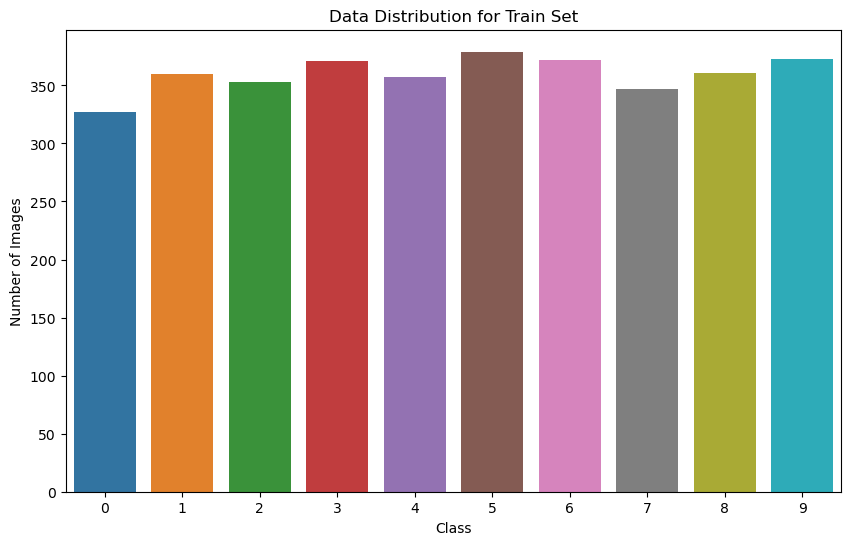

Validation Set Data Distribution:


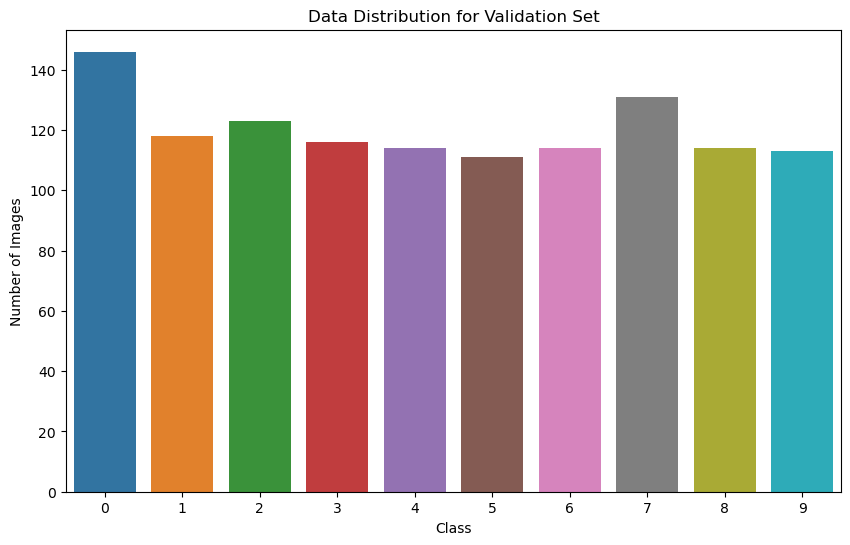

Test Set Data Distribution:


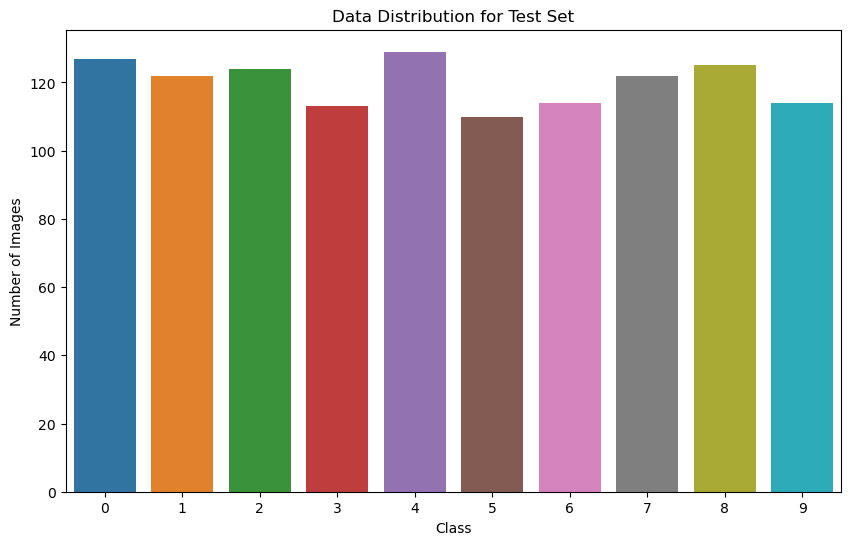

Train Set: 5 Images Per Class


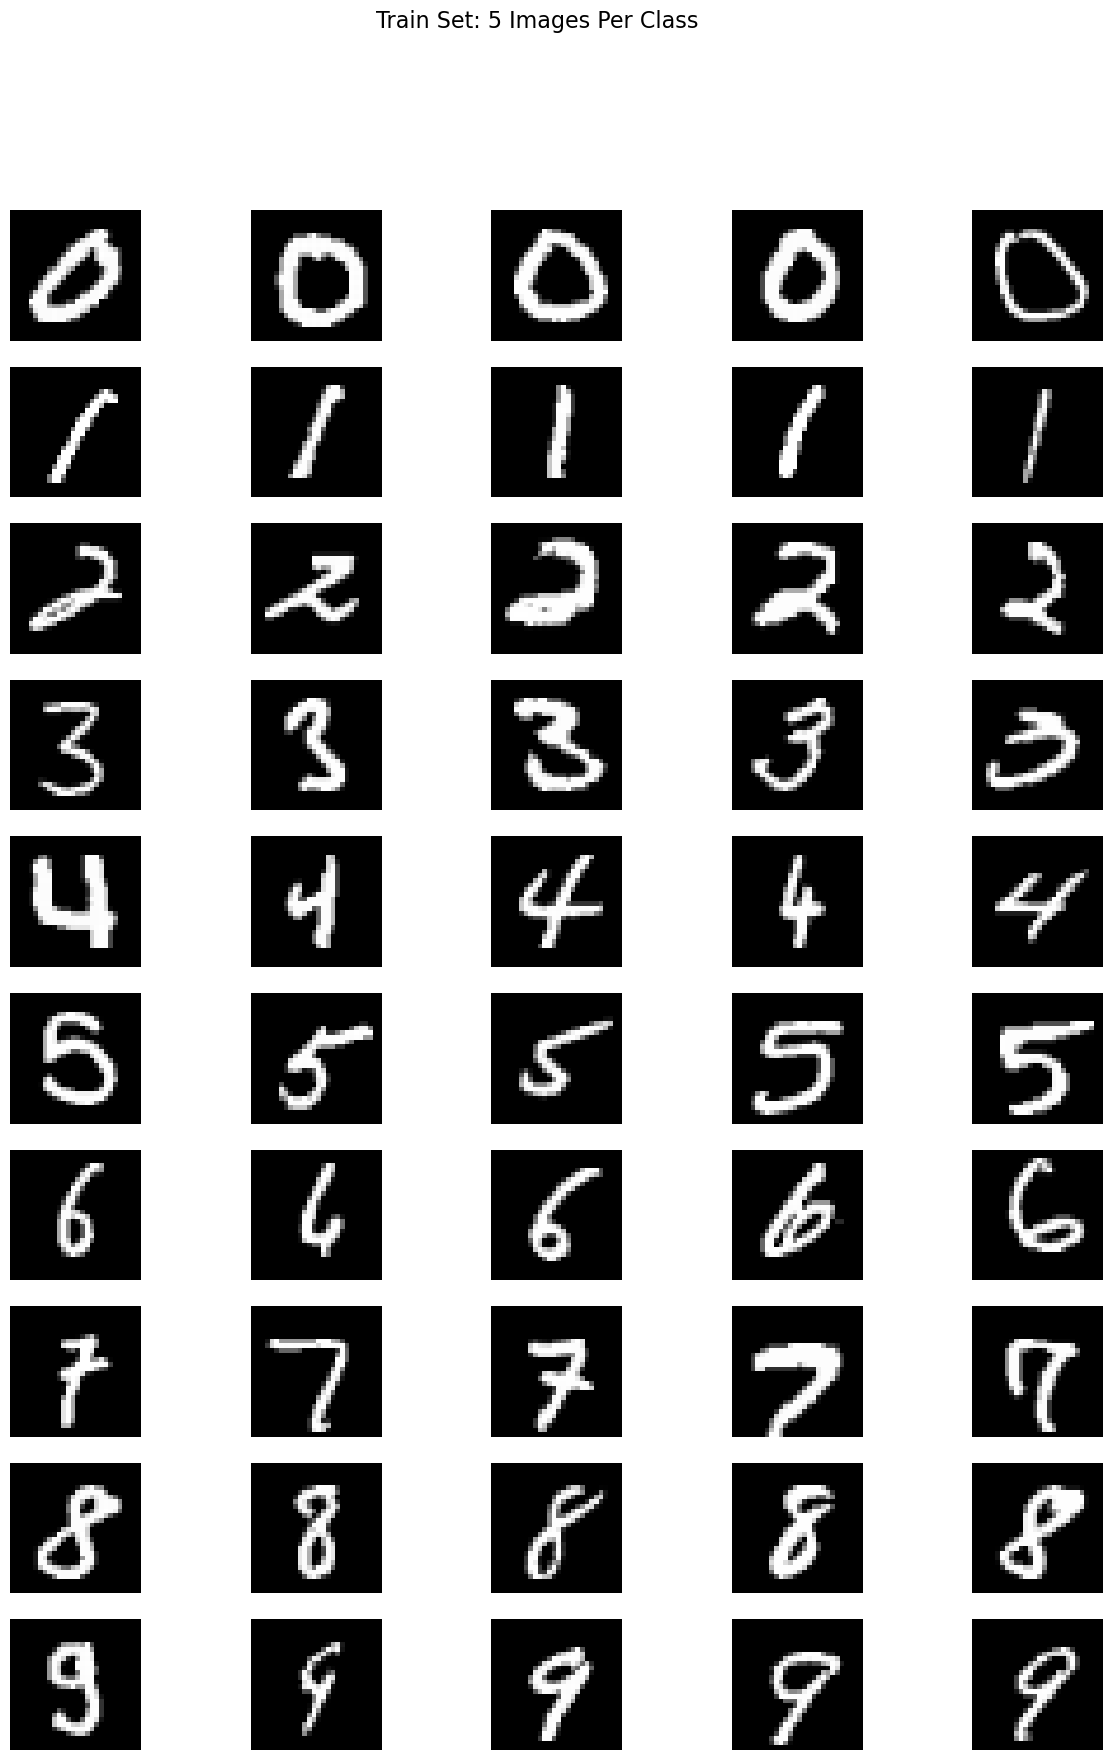

Validation Set: 5 Images Per Class


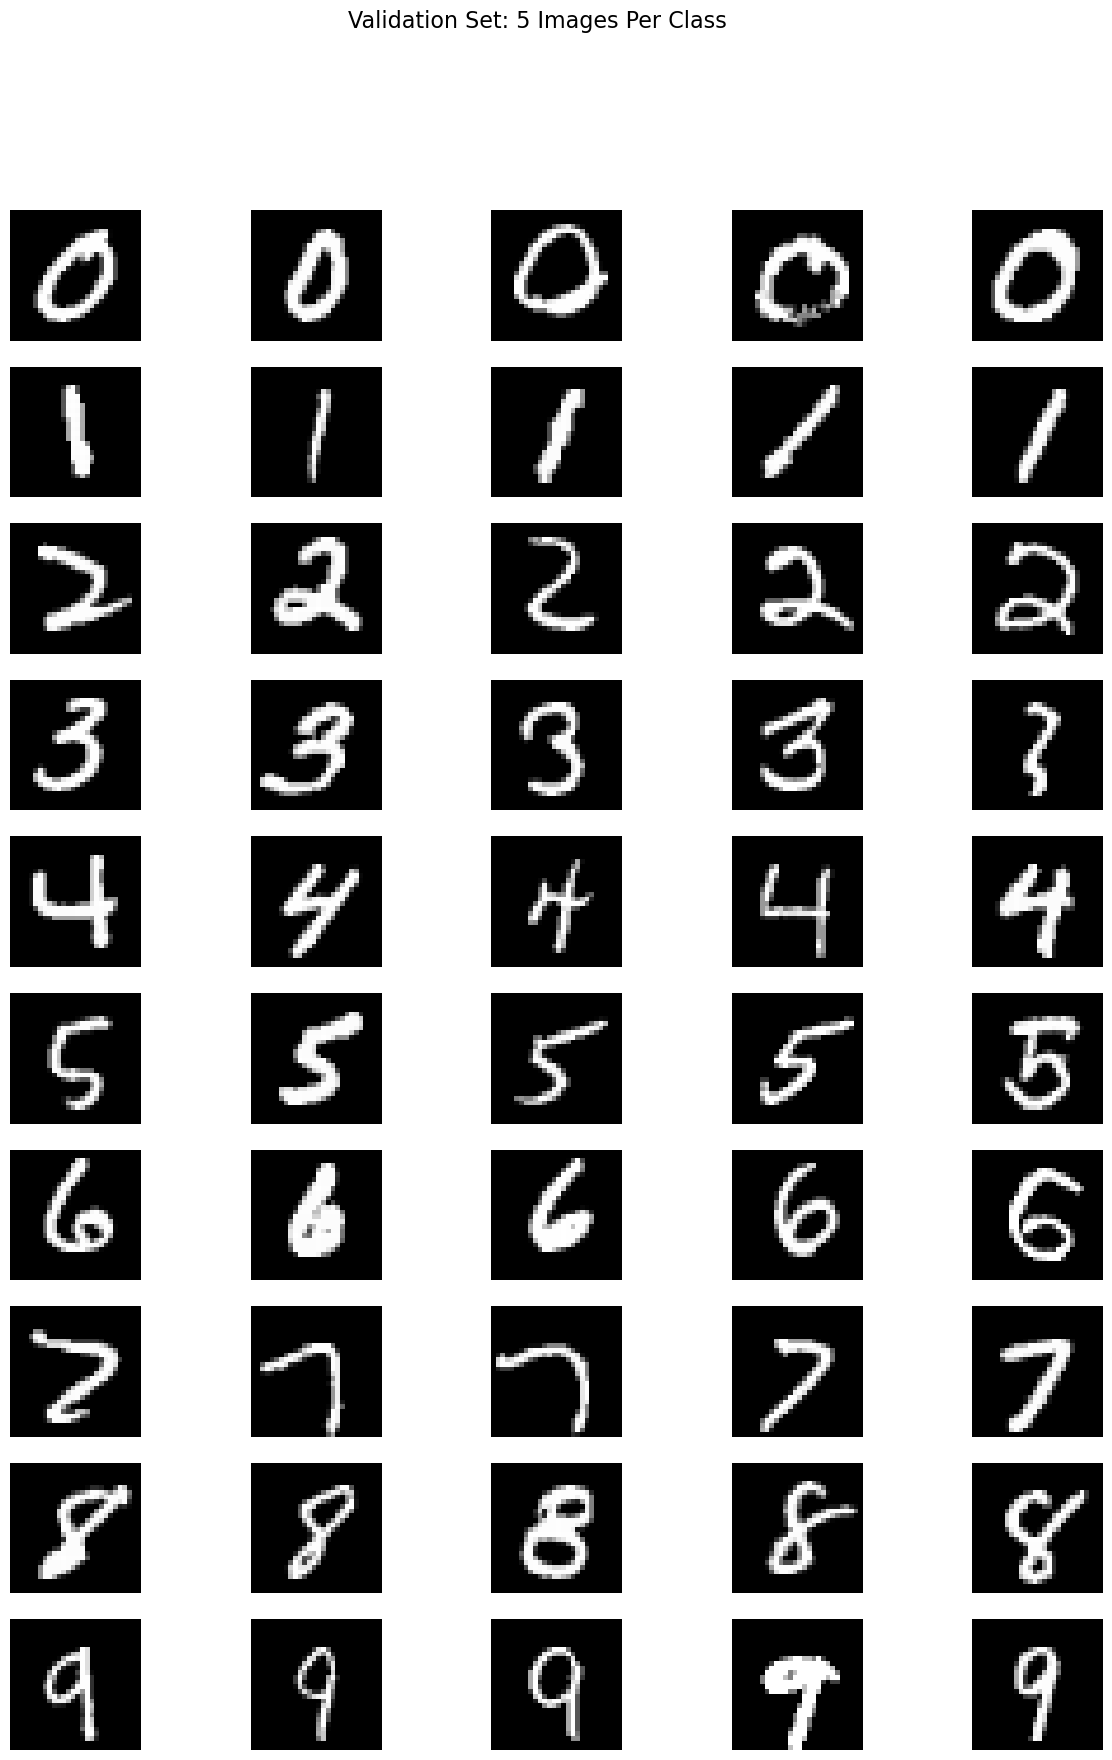

Test Set: 5 Images Per Class


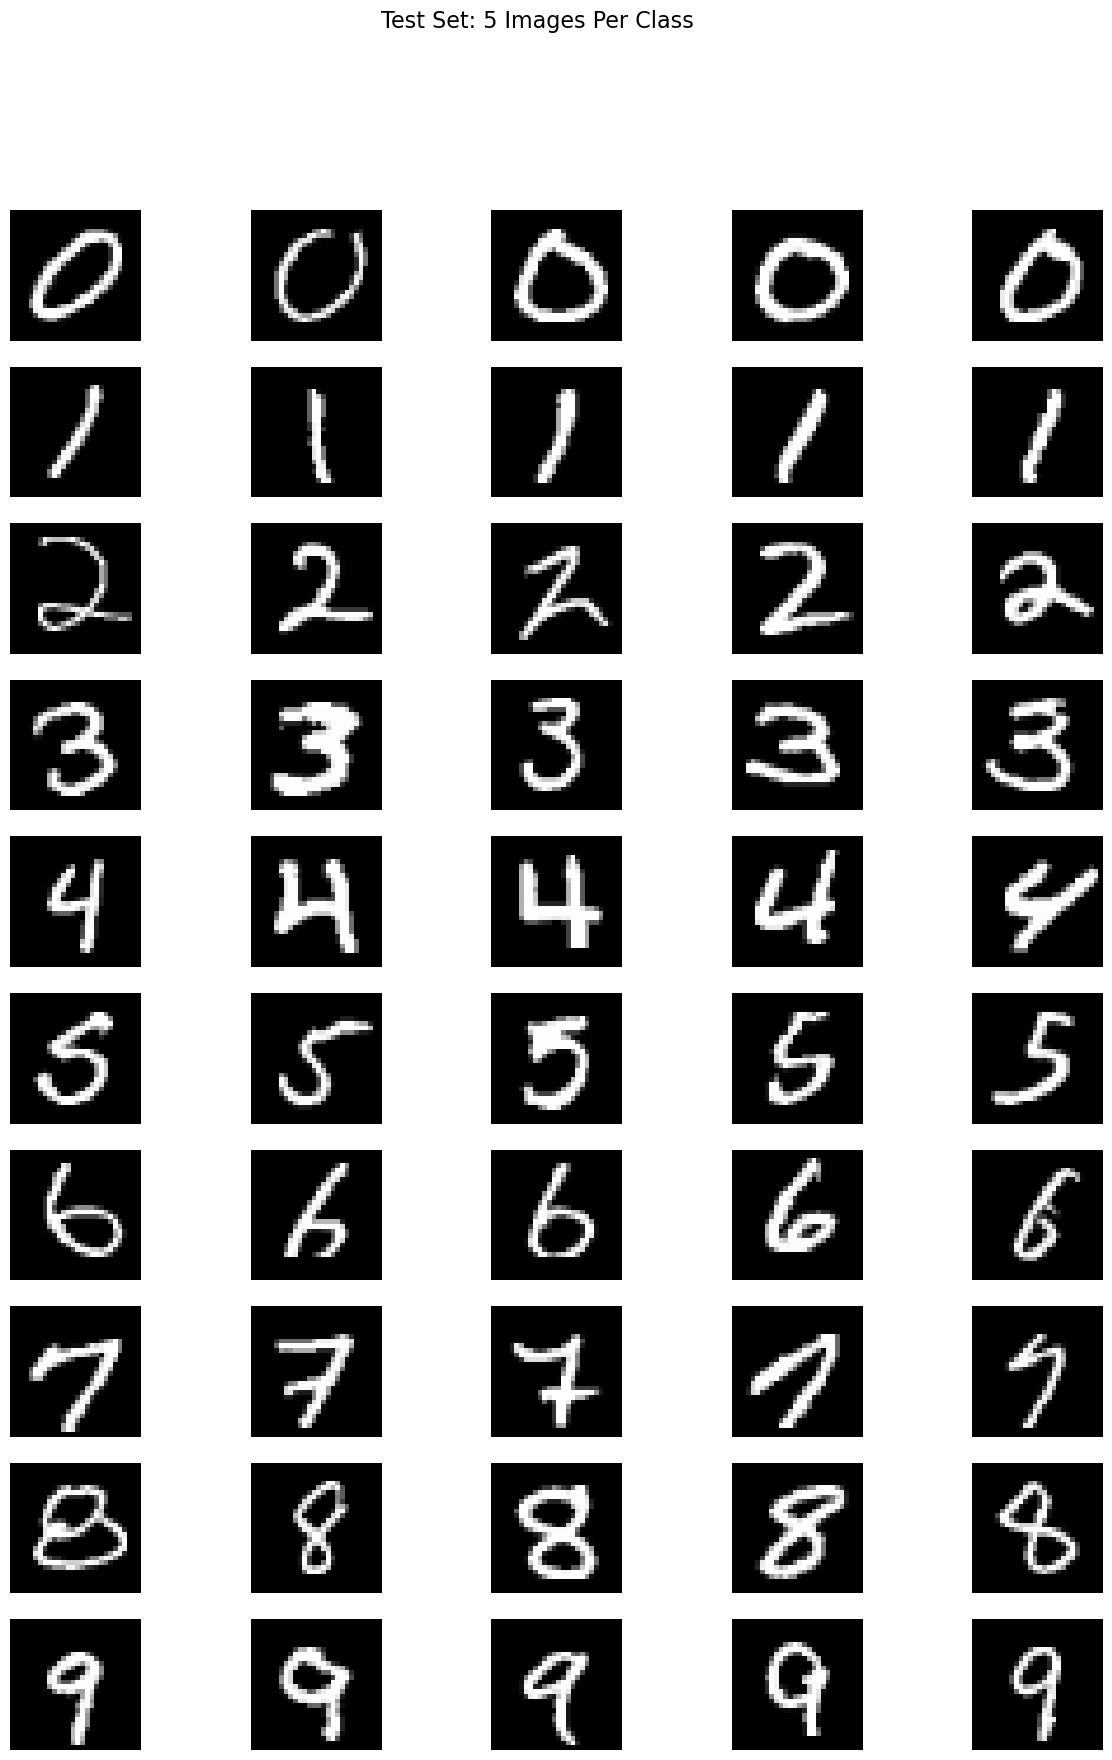


Train Set Metrics:
Total Number of Images: 3600
Number of Images per Class: {0: 327.0, 1: 360.0, 2: 353.0, 3: 371.0, 4: 357.0, 5: 379.0, 6: 372.0, 7: 347.0, 8: 361.0, 9: 373.0}
Total Image Size (in pixels): 2822400
Average Image Size (in pixels): 784.00
Total Size of Images (in bytes): 10.77 MB
Image Resolution (Height x Width): 28 x 28

Validation Set Metrics:
Total Number of Images: 1200
Number of Images per Class: {0: 146.0, 1: 118.0, 2: 123.0, 3: 116.0, 4: 114.0, 5: 111.0, 6: 114.0, 7: 131.0, 8: 114.0, 9: 113.0}
Total Image Size (in pixels): 940800
Average Image Size (in pixels): 784.00
Total Size of Images (in bytes): 3.59 MB
Image Resolution (Height x Width): 28 x 28

Test Set Metrics:
Total Number of Images: 1200
Number of Images per Class: {0: 127.0, 1: 122.0, 2: 124.0, 3: 113.0, 4: 129.0, 5: 110.0, 6: 114.0, 7: 122.0, 8: 125.0, 9: 114.0}
Total Image Size (in pixels): 940800
Average Image Size (in pixels): 784.00
Total Size of Images (in bytes): 3.59 MB
Image Resolution (Heigh

In [13]:
#perform_eda(train_images, train_labels, test_images, test_labels)
perform_eda(train_images, train_labels, val_images, val_labels, test_images, test_labels)

## Define Configurations and train, evaluate the model

1. Baseline model 
2. Model 1: Different optimizer (SGD)
3. Model 2: Different learning rate (reduced)
4. Model 3: More filters ([64, 128, 256])
5. Model 4: Larger feature map size (feature_map_size: 5)
6. Model 5: Higher dropout rate (0.4)
7. Model 6: Smaller batch size (64)
8. Model 7: More epochs (10)

In [14]:
# Define configurations
configurations = [
    # Baseline model
    {'optimizer': 'adam', 'learning_rate': 0.001, 'num_filters': [32, 64, 128], 'feature_map_size': 3, 'dropout_rate': 0.25, 'batch_size': 128, 'epochs': 5, 'description': 'Baseline model'},  
    # Model 1: Different optimizer
    {'optimizer': 'sgd', 'learning_rate': 0.001, 'num_filters': [32, 64, 128], 'feature_map_size': 3, 'dropout_rate': 0.25, 'batch_size': 64, 'epochs': 100, 'description': 'Different optimizer'},  
    # Model 2: Different learning rate
    {'optimizer': 'adam', 'learning_rate': 0.01, 'num_filters': [32, 64, 128], 'feature_map_size': 3, 'dropout_rate': 0.25, 'batch_size': 128, 'epochs': 5, 'description': 'Different learning rate'},  
    # Model 3: More filters
    {'optimizer': 'adam', 'learning_rate': 0.001, 'num_filters': [64, 128, 256], 'feature_map_size': 3, 'dropout_rate': 0.25, 'batch_size': 128, 'epochs': 5, 'description': 'More filters'},  
    # Model 4: Larger feature map size
    {'optimizer': 'adam', 'learning_rate': 0.001, 'num_filters': [32, 64, 128], 'feature_map_size': 5, 'dropout_rate': 0.25, 'batch_size': 128, 'epochs': 5, 'description': 'Larger feature map size'},  
    # Model 5: Higher dropout rate
    {'optimizer': 'adam', 'learning_rate': 0.001, 'num_filters': [32, 64, 128], 'feature_map_size': 3, 'dropout_rate': 0.4, 'batch_size': 128, 'epochs': 5, 'description': 'Higher dropout rate'},  
    # Model 6: Smaller batch size
    {'optimizer': 'adam', 'learning_rate': 0.001, 'num_filters': [32, 64, 128], 'feature_map_size': 3, 'dropout_rate': 0.25, 'batch_size': 64, 'epochs': 5, 'description': 'Smaller batch size'},  
    # Model 7: More epochs
    {'optimizer': 'adam', 'learning_rate': 0.001, 'num_filters': [32, 64, 128], 'feature_map_size': 3, 'dropout_rate': 0.25, 'batch_size': 128, 'epochs': 10, 'description': 'More epochs'}
]

Training model 1 with configuration: Baseline model


2024-09-18 12:52:22.974260: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-09-18 12:52:22.974660: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.73GiB deviceMemoryBandwidth: 836.37GiB/s
2024-09-18 12:52:22.974698: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-09-18 12:52:22.974737: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-09-18 12:52:22.974751: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2024-09-18 12:52:22.974766: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10

Epoch 1/5


2024-09-18 12:52:23.915982: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-09-18 12:52:24.173852: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2024-09-18 12:52:25.241489: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2024-09-18 12:52:25.287483: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


29/29 [==============================] - 13s 243ms/step - loss: 1.9928 - accuracy: 0.3453 - val_loss: 0.5697 - val_accuracy: 0.8425
Epoch 2/5
29/29 [==============================] - 0s 6ms/step - loss: 0.5366 - accuracy: 0.8308 - val_loss: 0.2338 - val_accuracy: 0.9433
Epoch 3/5
29/29 [==============================] - 0s 5ms/step - loss: 0.2600 - accuracy: 0.9163 - val_loss: 0.1640 - val_accuracy: 0.9567
Epoch 4/5
29/29 [==============================] - 0s 5ms/step - loss: 0.1638 - accuracy: 0.9492 - val_loss: 0.1551 - val_accuracy: 0.9583
Epoch 5/5
38/38 [==============================] - 2s 2ms/step - loss: 0.1302 - accuracy: 0.9583
Model saved to temp_model.h5
Model saved to Model_0.h5


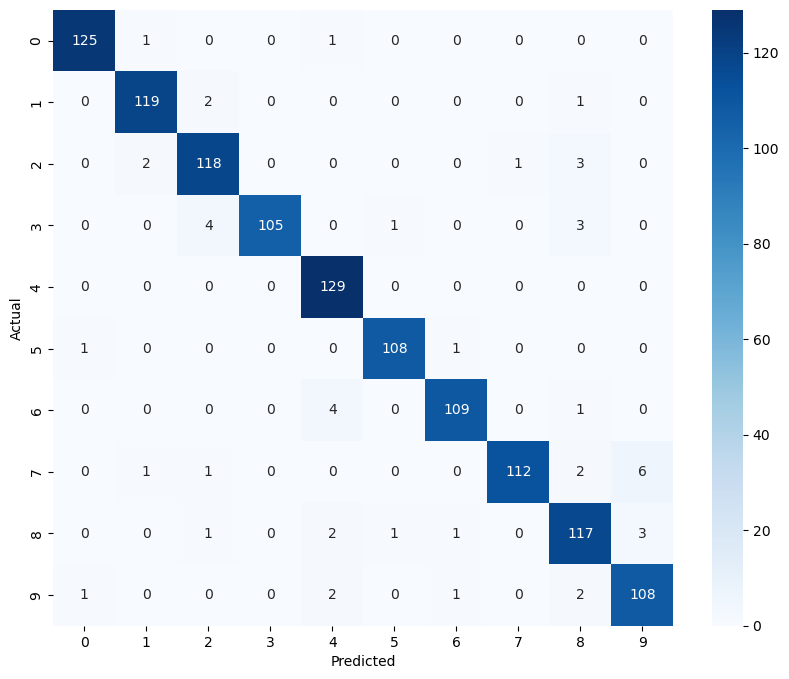

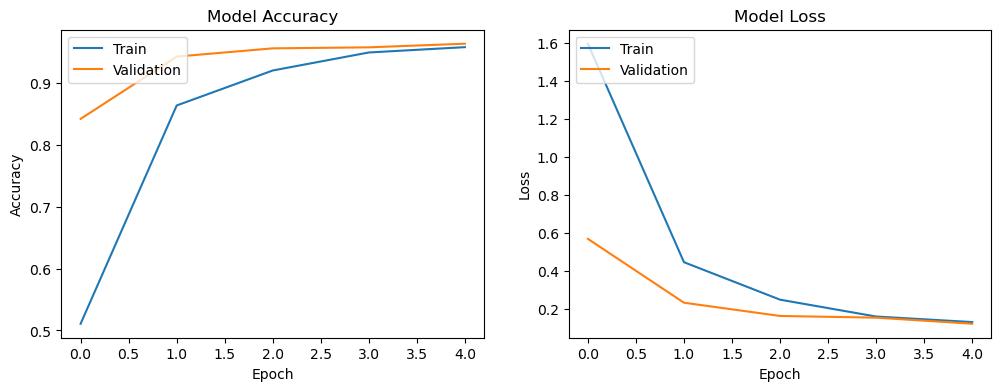

Training model 2 with configuration: Different optimizer
Epoch 1/100
57/57 [==============================] - 5s 7ms/step - loss: 2.2968 - accuracy: 0.1242 - val_loss: 2.2956 - val_accuracy: 0.1092
Epoch 2/100
57/57 [==============================] - 0s 4ms/step - loss: 2.2952 - accuracy: 0.1229 - val_loss: 2.2931 - val_accuracy: 0.1083
Epoch 3/100
57/57 [==============================] - 0s 4ms/step - loss: 2.2933 - accuracy: 0.1285 - val_loss: 2.2907 - val_accuracy: 0.1092
Epoch 4/100
57/57 [==============================] - 0s 4ms/step - loss: 2.2912 - accuracy: 0.1304 - val_loss: 2.2883 - val_accuracy: 0.1175
Epoch 5/100
57/57 [==============================] - 0s 4ms/step - loss: 2.2875 - accuracy: 0.1401 - val_loss: 2.2860 - val_accuracy: 0.1217
Epoch 6/100
57/57 [==============================] - 0s 4ms/step - loss: 2.2858 - accuracy: 0.1440 - val_loss: 2.2838 - val_accuracy: 0.1317
Epoch 7/100
57/57 [==============================] - 0s 4ms/step - loss: 2.2833 - accuracy: 0.148

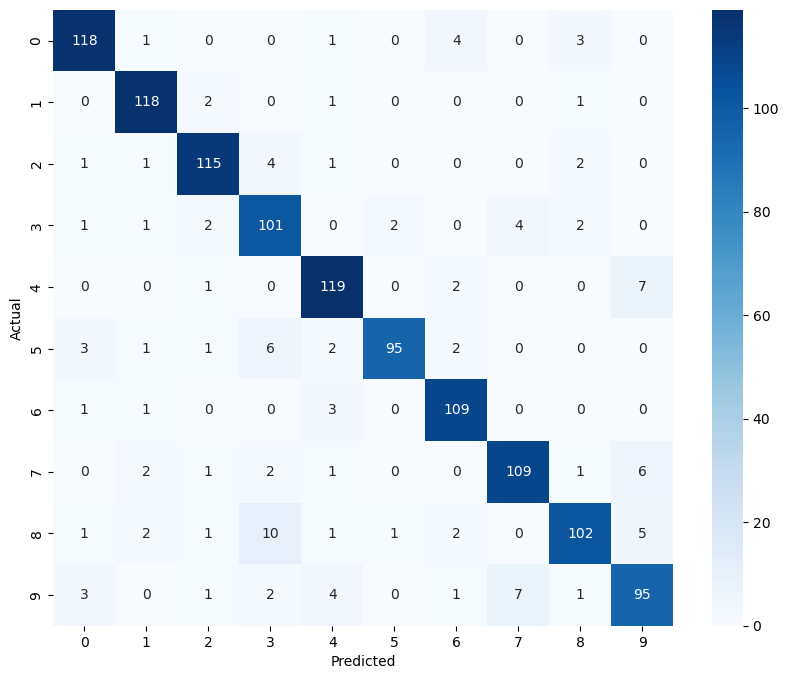

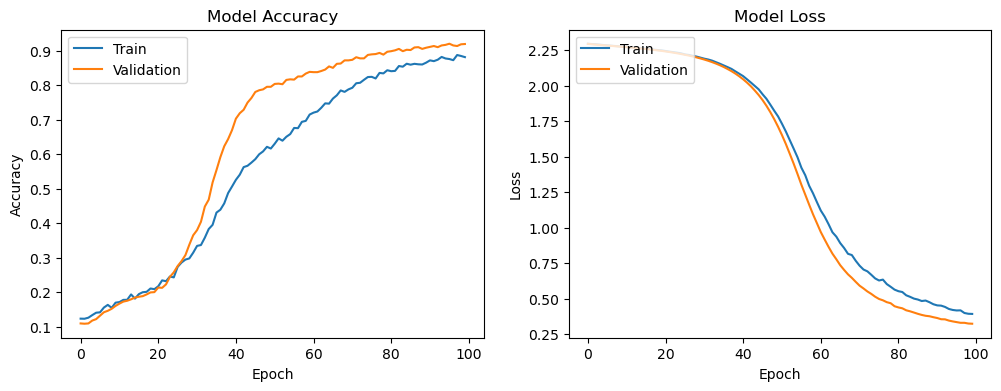

Training model 3 with configuration: Different learning rate
Epoch 1/5
29/29 [==============================] - 1s 11ms/step - loss: 2.5138 - accuracy: 0.1716 - val_loss: 1.0911 - val_accuracy: 0.6008
Epoch 2/5
29/29 [==============================] - 0s 5ms/step - loss: 0.8983 - accuracy: 0.6923 - val_loss: 0.2338 - val_accuracy: 0.9308
Epoch 3/5
29/29 [==============================] - 0s 5ms/step - loss: 0.3192 - accuracy: 0.9097 - val_loss: 0.1744 - val_accuracy: 0.9542
Epoch 4/5
29/29 [==============================] - 0s 5ms/step - loss: 0.2073 - accuracy: 0.9383 - val_loss: 0.1881 - val_accuracy: 0.9450
Epoch 5/5
38/38 [==============================] - 0s 2ms/step - loss: 0.1697 - accuracy: 0.9442
Model saved to temp_model.h5
Model saved to Model_2.h5


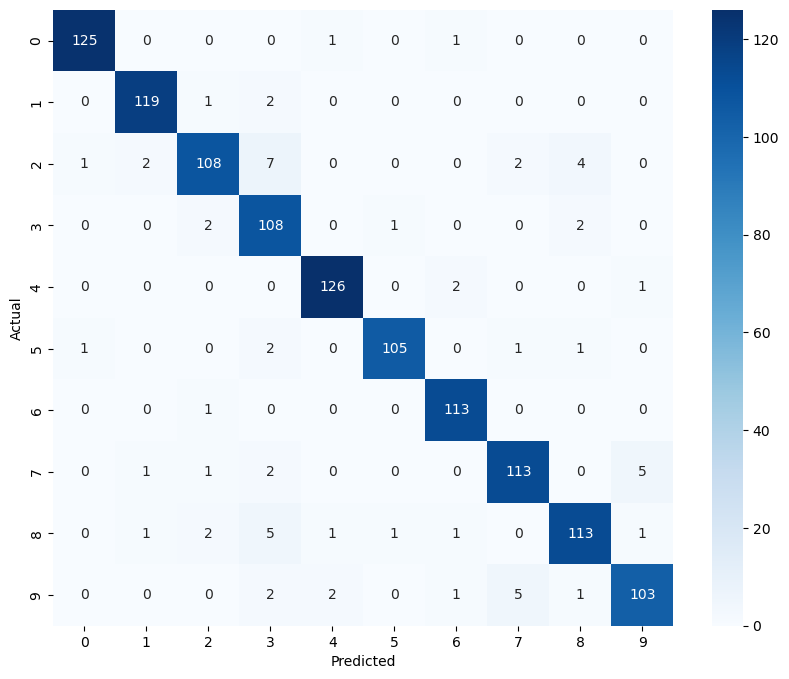

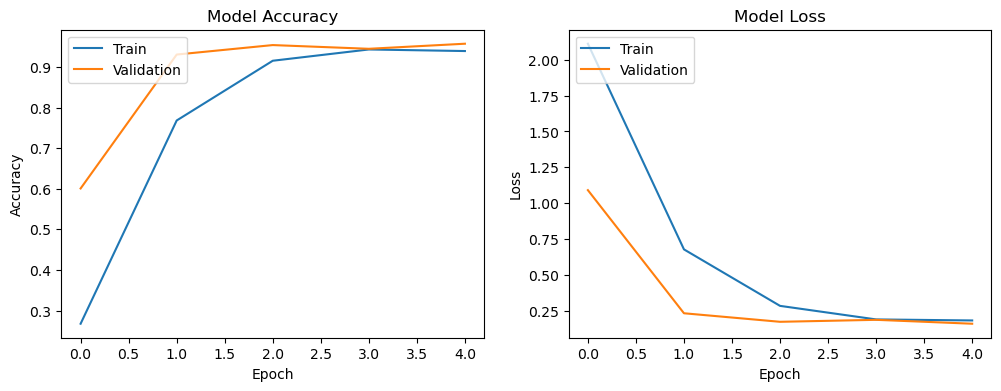

Training model 4 with configuration: More filters
Epoch 1/5
29/29 [==============================] - 12s 241ms/step - loss: 1.8564 - accuracy: 0.3521 - val_loss: 0.4322 - val_accuracy: 0.8808
Epoch 2/5
29/29 [==============================] - 0s 7ms/step - loss: 0.4331 - accuracy: 0.8661 - val_loss: 0.1834 - val_accuracy: 0.9508
Epoch 3/5
29/29 [==============================] - 0s 7ms/step - loss: 0.2149 - accuracy: 0.9363 - val_loss: 0.1459 - val_accuracy: 0.9633
Epoch 4/5
29/29 [==============================] - 0s 7ms/step - loss: 0.1598 - accuracy: 0.9515 - val_loss: 0.1141 - val_accuracy: 0.9692
Epoch 5/5
38/38 [==============================] - 2s 2ms/step - loss: 0.1101 - accuracy: 0.9625
Model saved to temp_model.h5
Model saved to Model_3.h5


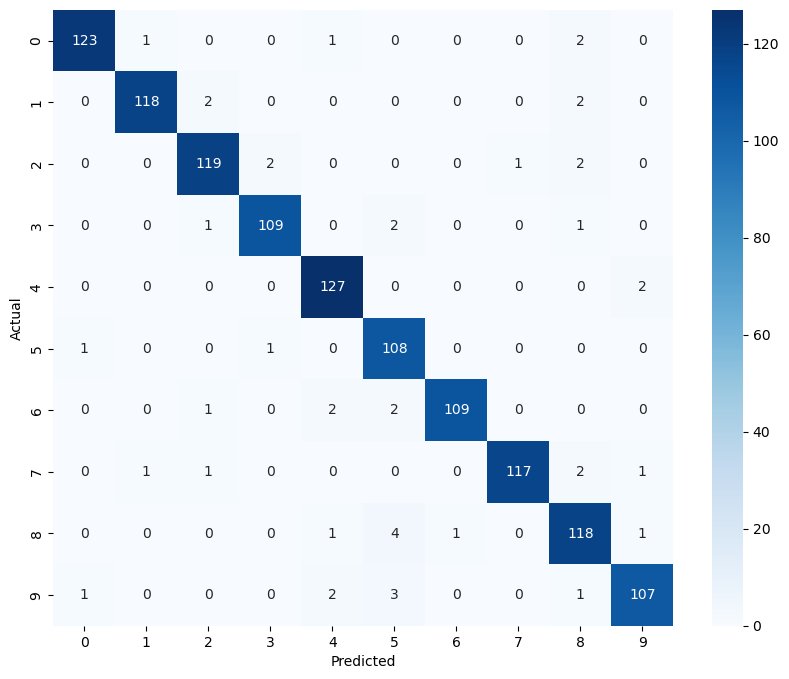

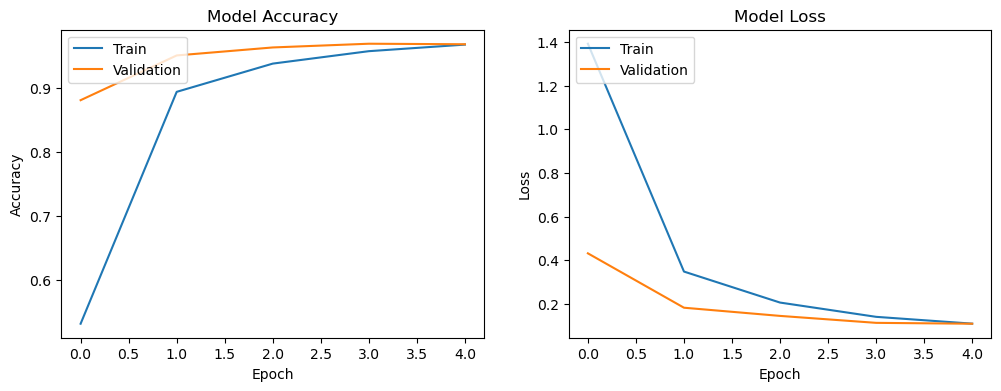

Training model 5 with configuration: Larger feature map size
Epoch 1/5
29/29 [==============================] - 10s 214ms/step - loss: 1.7842 - accuracy: 0.3805 - val_loss: 0.3290 - val_accuracy: 0.9058
Epoch 2/5
29/29 [==============================] - 0s 6ms/step - loss: 0.4066 - accuracy: 0.8798 - val_loss: 0.2020 - val_accuracy: 0.9417
Epoch 3/5
29/29 [==============================] - 0s 6ms/step - loss: 0.2256 - accuracy: 0.9263 - val_loss: 0.1586 - val_accuracy: 0.9592
Epoch 4/5
29/29 [==============================] - 0s 6ms/step - loss: 0.1412 - accuracy: 0.9577 - val_loss: 0.1115 - val_accuracy: 0.9725
Epoch 5/5
38/38 [==============================] - 2s 2ms/step - loss: 0.1165 - accuracy: 0.9617
Model saved to temp_model.h5
Model saved to Model_4.h5


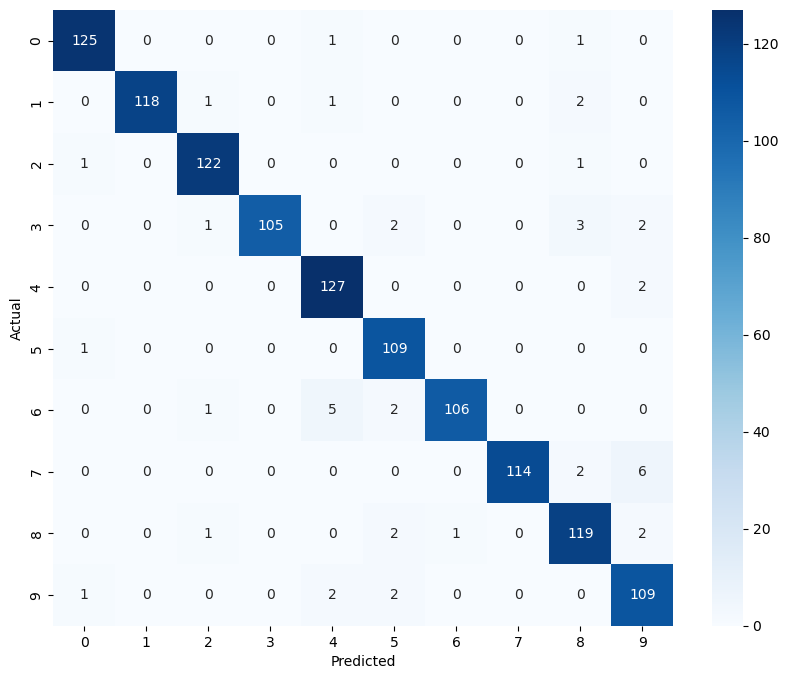

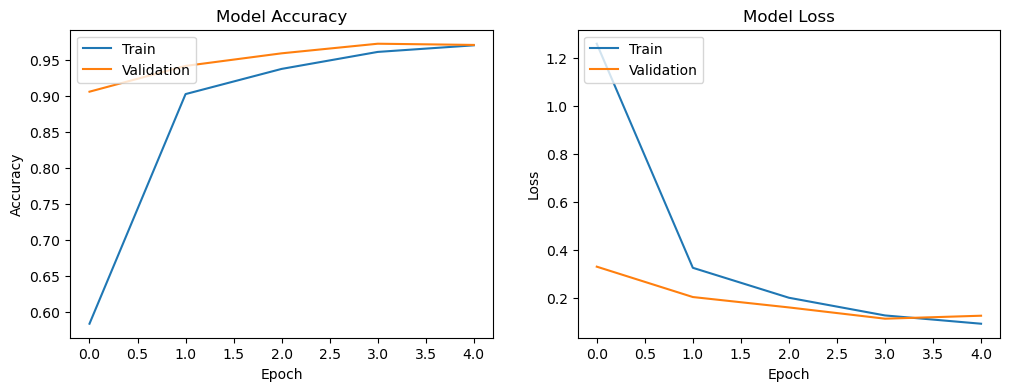

Training model 6 with configuration: Higher dropout rate
Epoch 1/5
29/29 [==============================] - 1s 18ms/step - loss: 2.0477 - accuracy: 0.2737 - val_loss: 0.6163 - val_accuracy: 0.8467
Epoch 2/5
29/29 [==============================] - 0s 5ms/step - loss: 0.6734 - accuracy: 0.7774 - val_loss: 0.2546 - val_accuracy: 0.9350
Epoch 3/5
29/29 [==============================] - 0s 5ms/step - loss: 0.3363 - accuracy: 0.8972 - val_loss: 0.1772 - val_accuracy: 0.9517
Epoch 4/5
29/29 [==============================] - 0s 5ms/step - loss: 0.2633 - accuracy: 0.9219 - val_loss: 0.1697 - val_accuracy: 0.9583
Epoch 5/5
38/38 [==============================] - 0s 2ms/step - loss: 0.1311 - accuracy: 0.9592
Model saved to temp_model.h5
Model saved to Model_5.h5


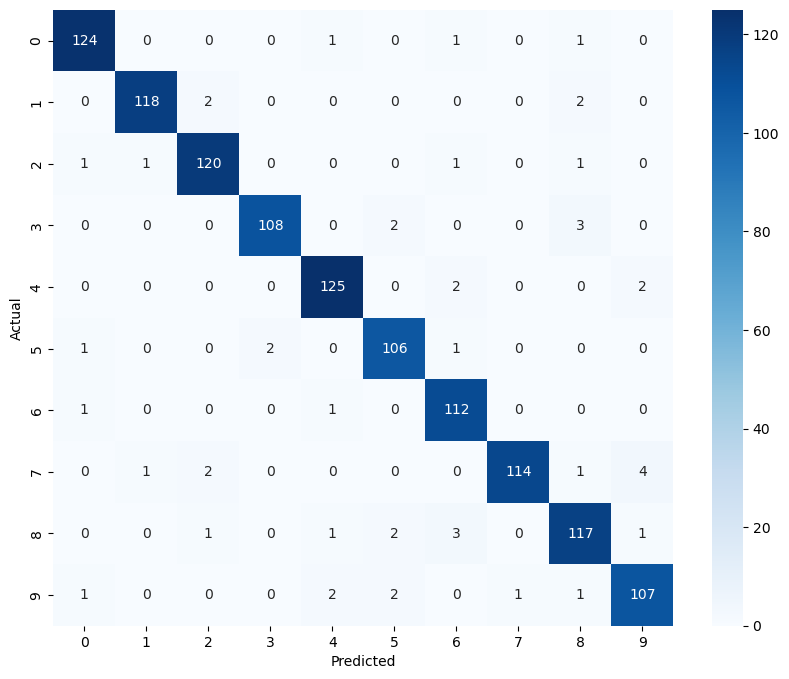

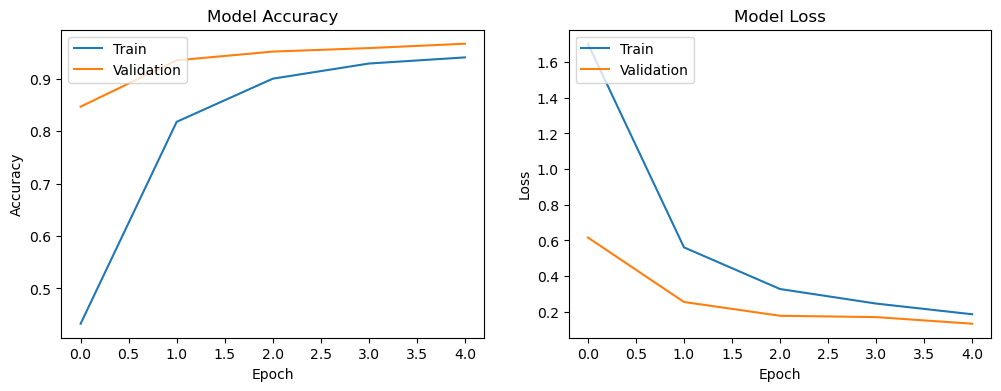

Training model 7 with configuration: Smaller batch size
Epoch 1/5
57/57 [==============================] - 1s 7ms/step - loss: 1.7666 - accuracy: 0.3944 - val_loss: 0.3069 - val_accuracy: 0.9175
Epoch 2/5
57/57 [==============================] - 0s 4ms/step - loss: 0.3457 - accuracy: 0.8922 - val_loss: 0.1858 - val_accuracy: 0.9517
Epoch 3/5
57/57 [==============================] - 0s 4ms/step - loss: 0.1905 - accuracy: 0.9401 - val_loss: 0.1572 - val_accuracy: 0.9583
Epoch 4/5
57/57 [==============================] - 0s 4ms/step - loss: 0.1312 - accuracy: 0.9598 - val_loss: 0.1194 - val_accuracy: 0.9642
Epoch 5/5
38/38 [==============================] - 0s 2ms/step - loss: 0.1219 - accuracy: 0.9617
Model saved to temp_model.h5
Model saved to Model_6.h5


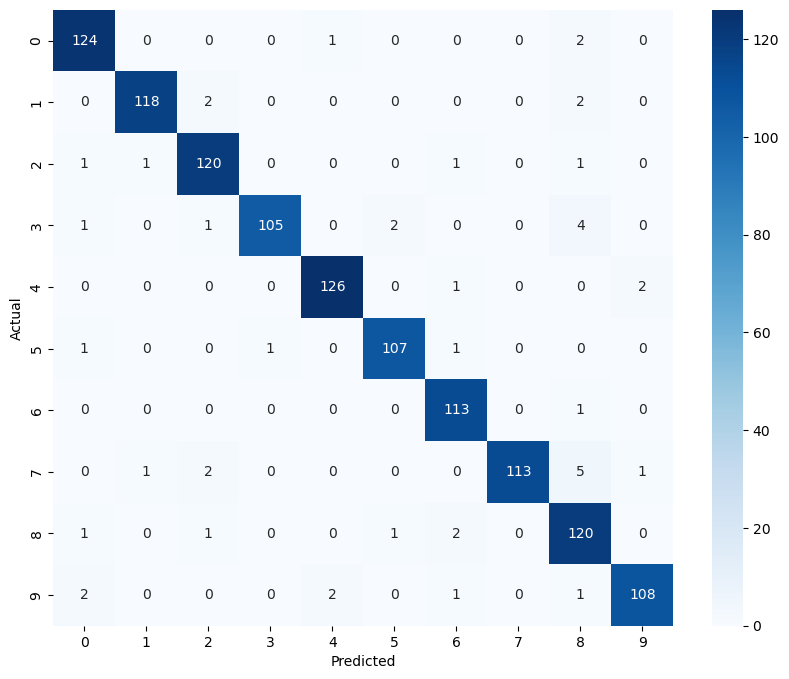

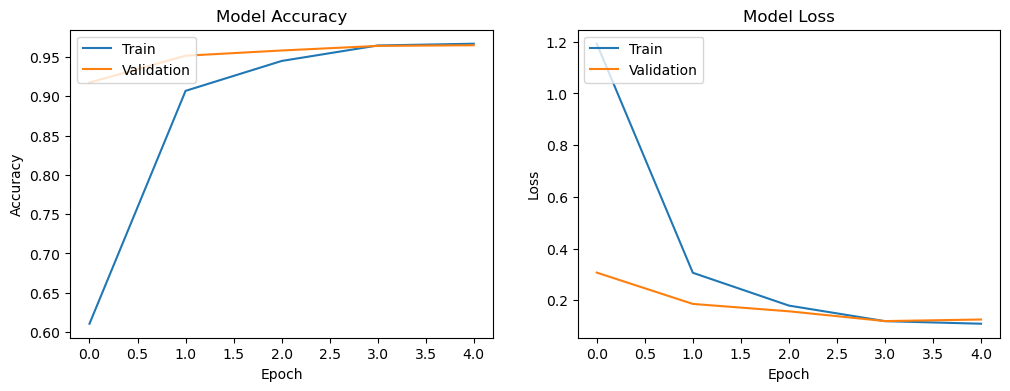

Training model 8 with configuration: More epochs
Epoch 1/10
29/29 [==============================] - 1s 11ms/step - loss: 1.9604 - accuracy: 0.3472 - val_loss: 0.4668 - val_accuracy: 0.8717
Epoch 2/10
29/29 [==============================] - 0s 5ms/step - loss: 0.5134 - accuracy: 0.8367 - val_loss: 0.2641 - val_accuracy: 0.9283
Epoch 3/10
29/29 [==============================] - 0s 5ms/step - loss: 0.2905 - accuracy: 0.9035 - val_loss: 0.1828 - val_accuracy: 0.9542
Epoch 4/10
29/29 [==============================] - 0s 5ms/step - loss: 0.1838 - accuracy: 0.9410 - val_loss: 0.1484 - val_accuracy: 0.9600
Epoch 5/10
29/29 [==============================] - 0s 5ms/step - loss: 0.1304 - accuracy: 0.9614 - val_loss: 0.1612 - val_accuracy: 0.9550
Epoch 6/10
29/29 [==============================] - 0s 5ms/step - loss: 0.1525 - accuracy: 0.9567 - val_loss: 0.1257 - val_accuracy: 0.9642
Epoch 7/10
29/29 [==============================] - 0s 5ms/step - loss: 0.1228 - accuracy: 0.9616 - val_loss: 

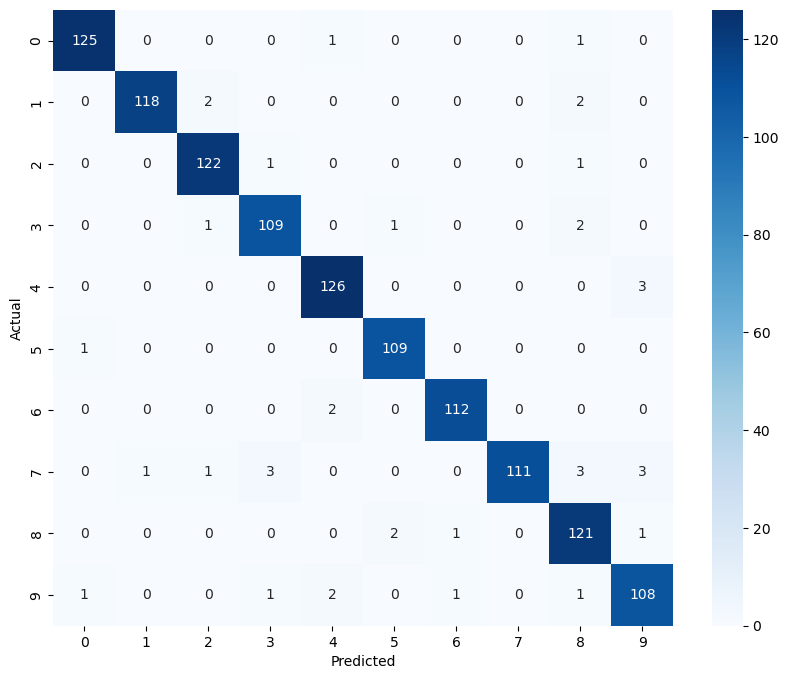

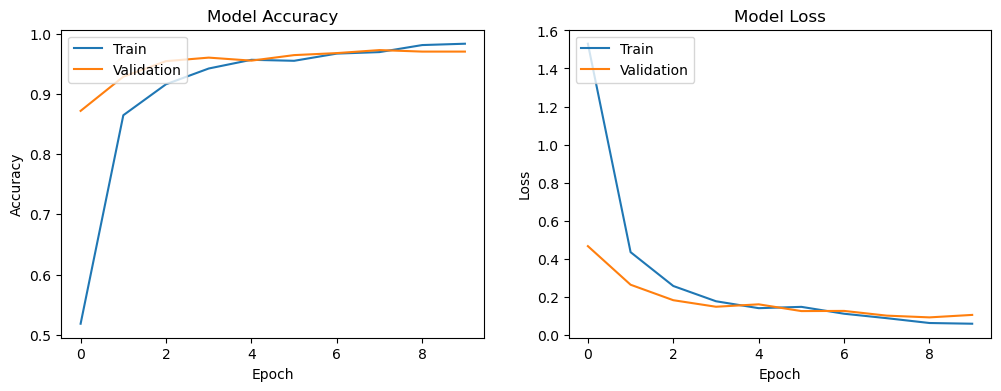

   Model              Description  Training Time (s)  Training Accuracy (%)  \
0      1           Baseline model          13.577489              95.861113   
1      2      Different optimizer          27.011048              88.194442   
2      3  Different learning rate           1.368160              93.944442   
3      4             More filters          12.407025              96.777779   
4      5  Larger feature map size          11.157699              97.027779   
5      6      Higher dropout rate           1.560200              94.055557   
6      7       Smaller batch size           1.709518              96.694446   
7      8              More epochs           2.103911              98.305553   

   Validation Accuracy (%)  Testing Time (s)  Testing Accuracy (%)  \
0                96.416664          1.968260             95.833331   
1                92.000002          0.105424             90.083331   
2                95.749998          0.105299             94.416666   
3       

In [15]:
# Collect and display results
df_results = collect_results(configurations, train_images, train_labels, val_images, val_labels, test_images, test_labels)
print(df_results)

## Compare with baseline and visualize predictions

In [16]:
#df_comparison = compare_with_baseline2(df_results)
print("Comparison with Baseline Model:")
#print(df_comparison.to_string(index=True))
styled_comparison = compare_with_baseline(df_results)
styled_comparison

Comparison with Baseline Model:


Model,Training Time (s),Training Accuracy (%),Validation Accuracy (%),Testing Time (s),Testing Accuracy (%),Model Size (MB)
Baseline model,13.58,95.86,96.42,1.97,95.83,2.82
Different optimizer,27.01,88.19,92.00,0.11,90.08,0.95
Different learning rate,1.37,93.94,95.75,0.11,94.42,2.82
More filters,12.41,96.78,96.83,2.07,96.25,7.67
Larger feature map size,11.16,97.03,97.08,1.79,96.17,4.70
Higher dropout rate,1.56,94.06,96.67,0.10,95.92,2.82
Smaller batch size,1.71,96.69,96.50,0.10,96.17,2.82
More epochs,2.10,98.31,97.00,0.10,96.75,2.82


Model loaded from Model_6.h5
Model loaded from Model_0.h5
Visualizing predictions for Model_0.h5...


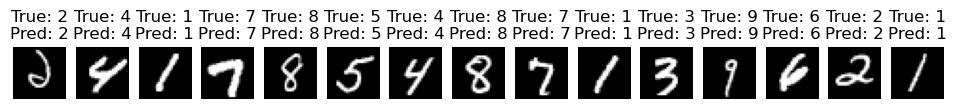

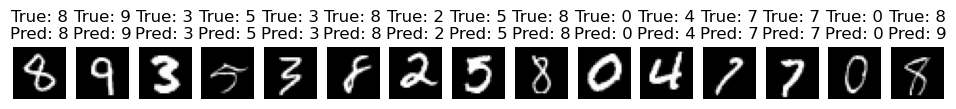

Model loaded from Model_1.h5
Visualizing predictions for Model_1.h5...


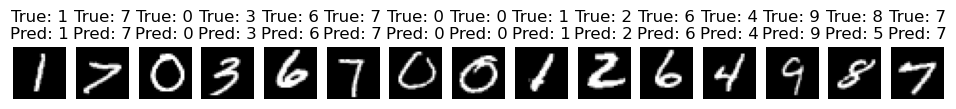

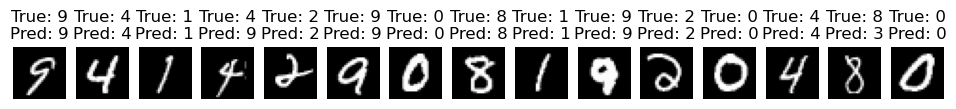

Model loaded from Model_2.h5
Visualizing predictions for Model_2.h5...


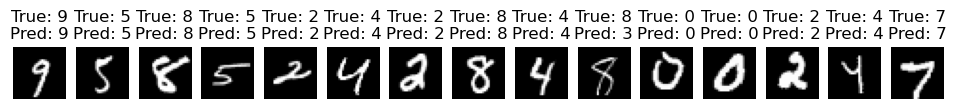

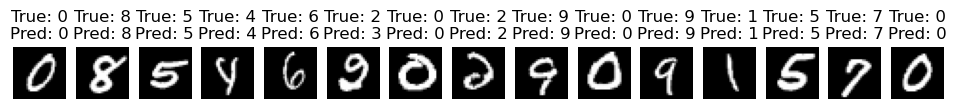

Model loaded from Model_3.h5
Visualizing predictions for Model_3.h5...


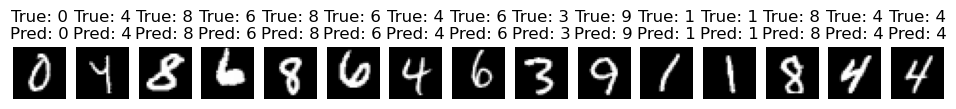

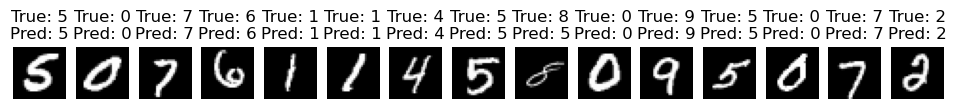

Model loaded from Model_4.h5
Visualizing predictions for Model_4.h5...


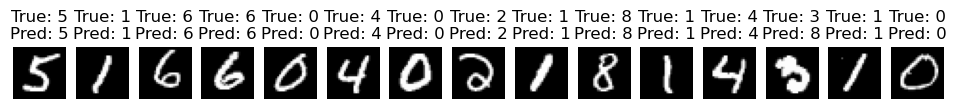

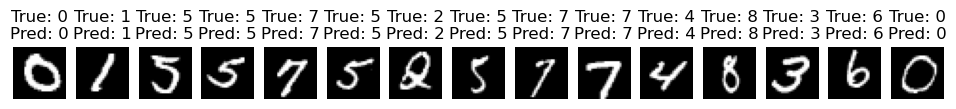

Model loaded from Model_5.h5
Visualizing predictions for Model_5.h5...


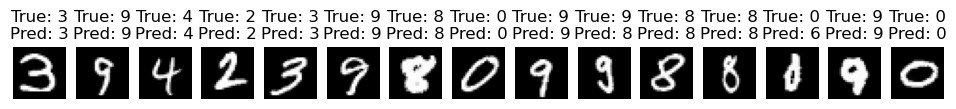

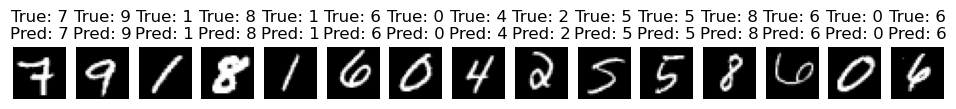

Model loaded from Model_6.h5
Visualizing predictions for Model_6.h5...


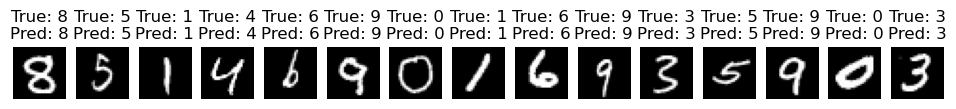

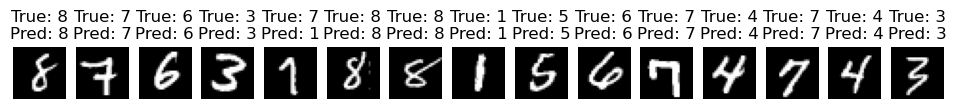

Model loaded from Model_7.h5
Visualizing predictions for Model_7.h5...


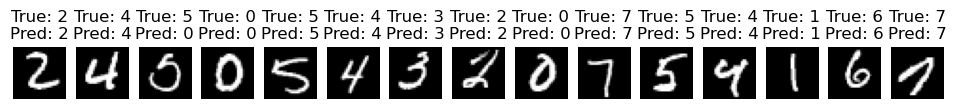

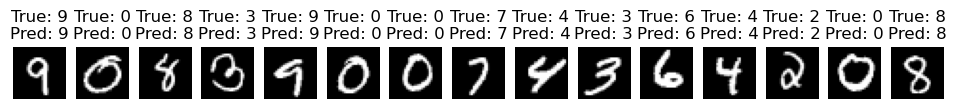

In [17]:
loaded_model = load_model('Model_6.h5')

visualize_all_models(range(8), test_images, test_labels, num_samples=15)

## Outlier Testing

I have used 10 outlier characters from cyrillic-mnist. It is characters instead of numbers. 

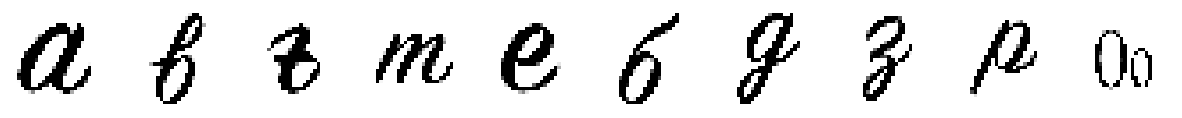

Model loaded from Model_0.h5
Model loaded from Model_1.h5
Model loaded from Model_2.h5
Model loaded from Model_3.h5
Model loaded from Model_4.h5
Model loaded from Model_5.h5
Model loaded from Model_6.h5
Model loaded from Model_7.h5
Model 0:


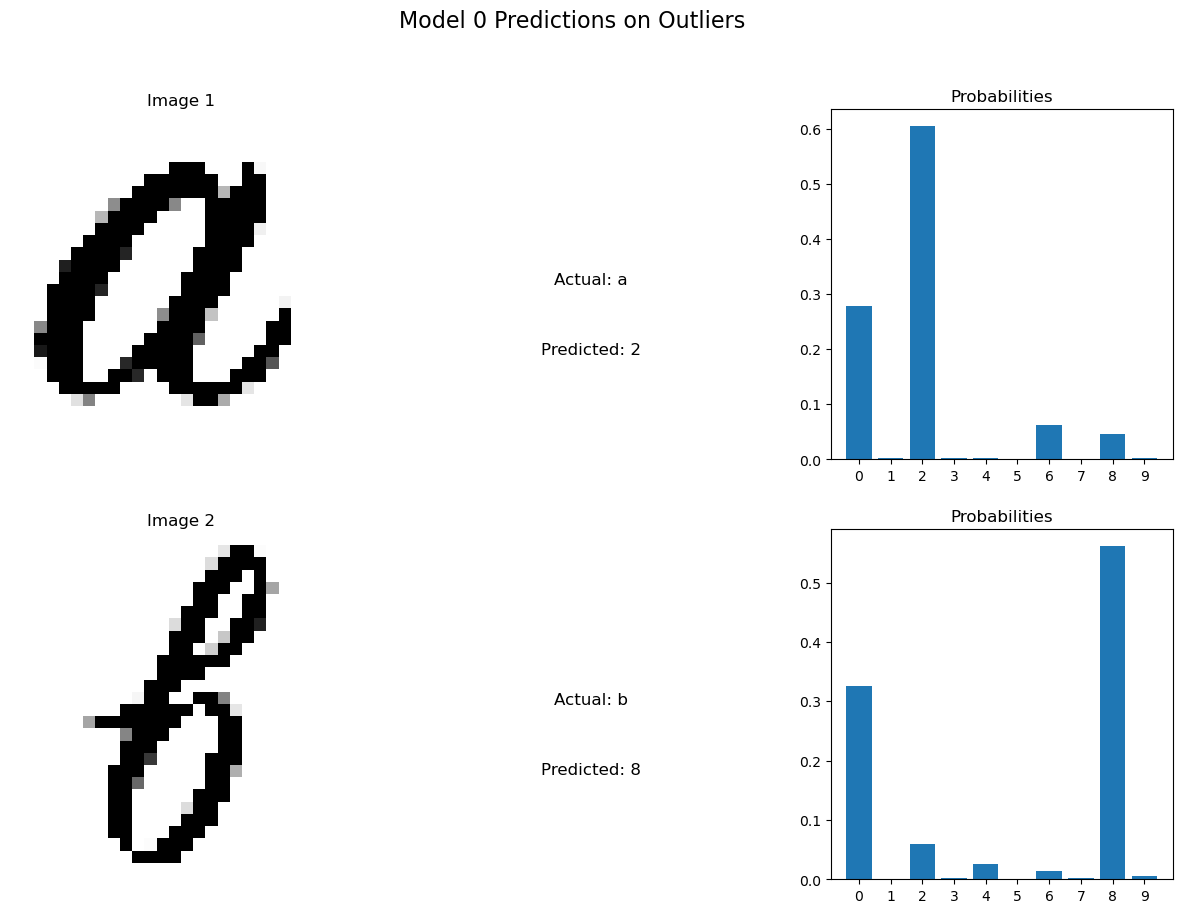

Model 1:


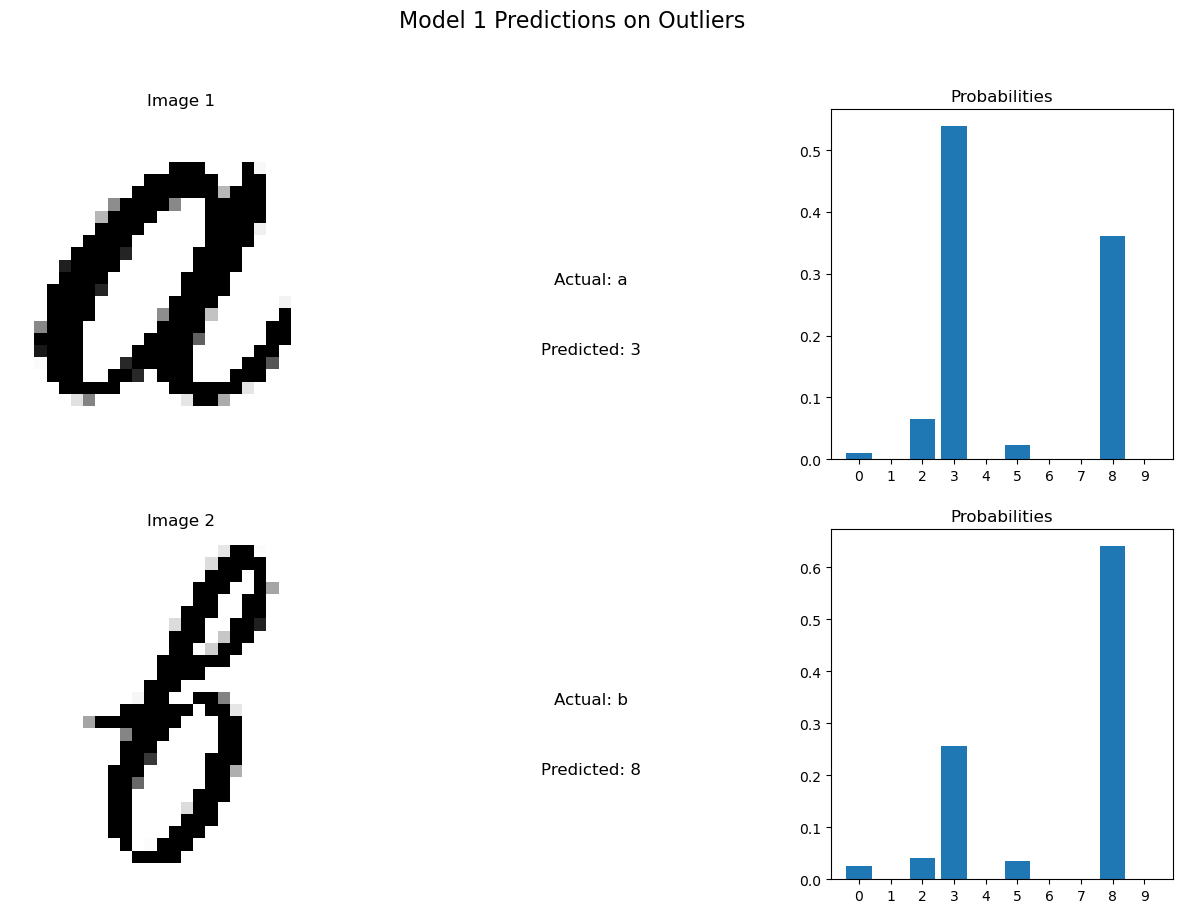

Model 2:


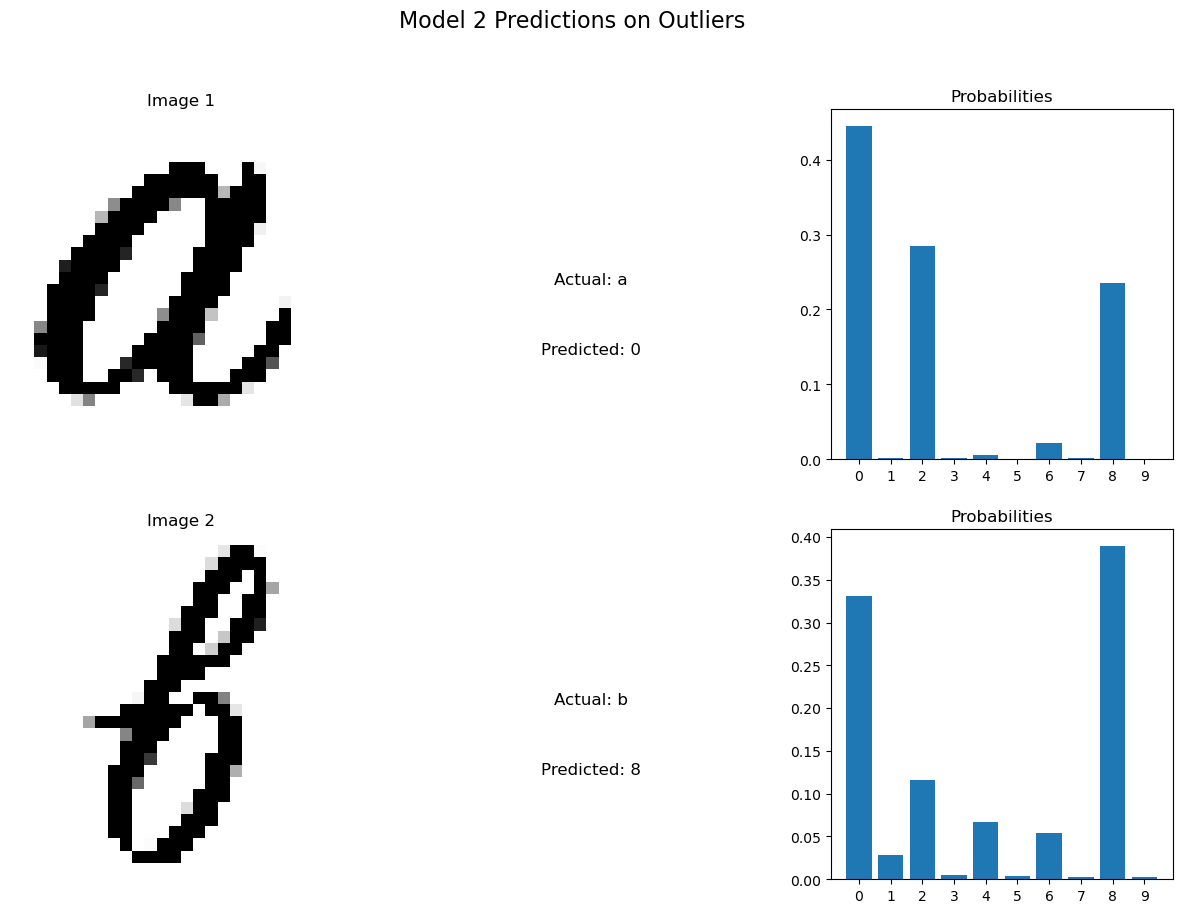

Model 3:


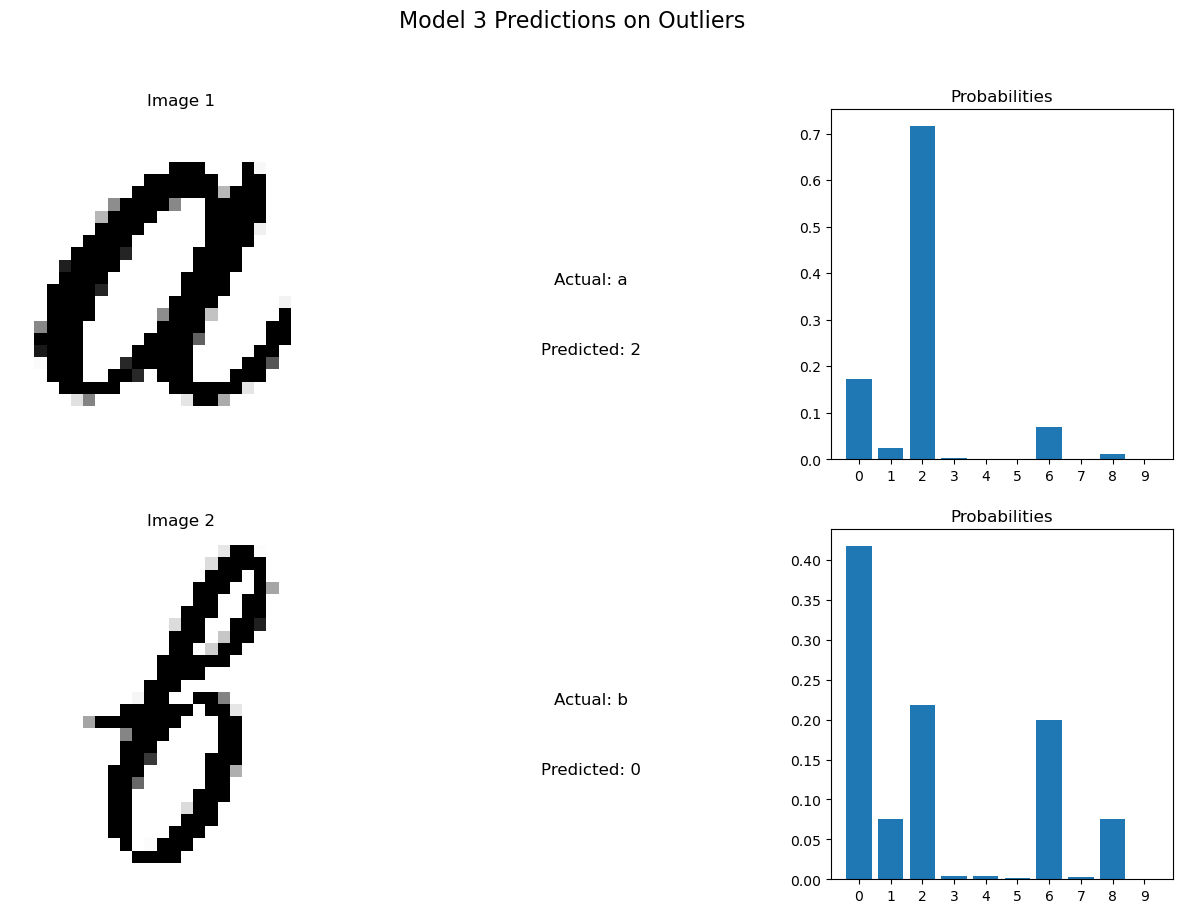

Model 4:


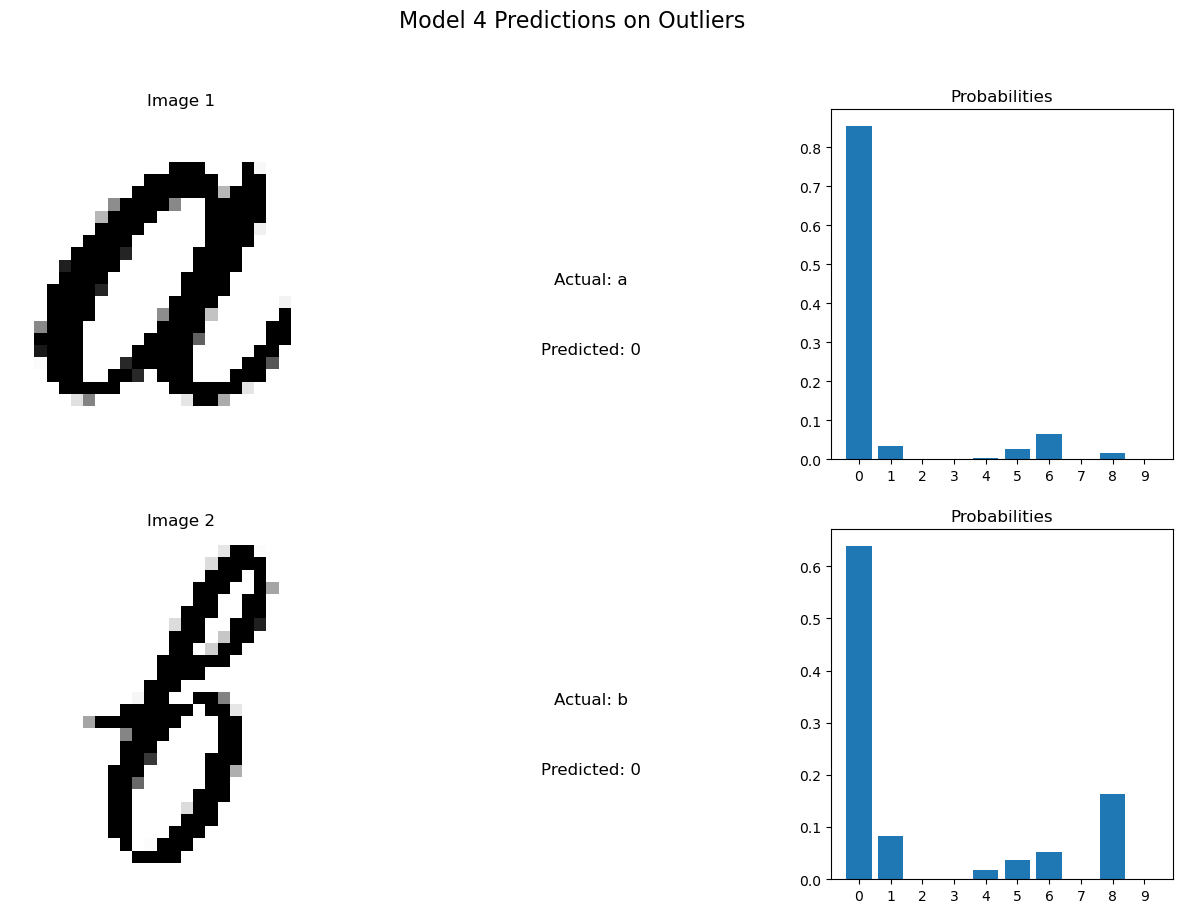

Model 5:


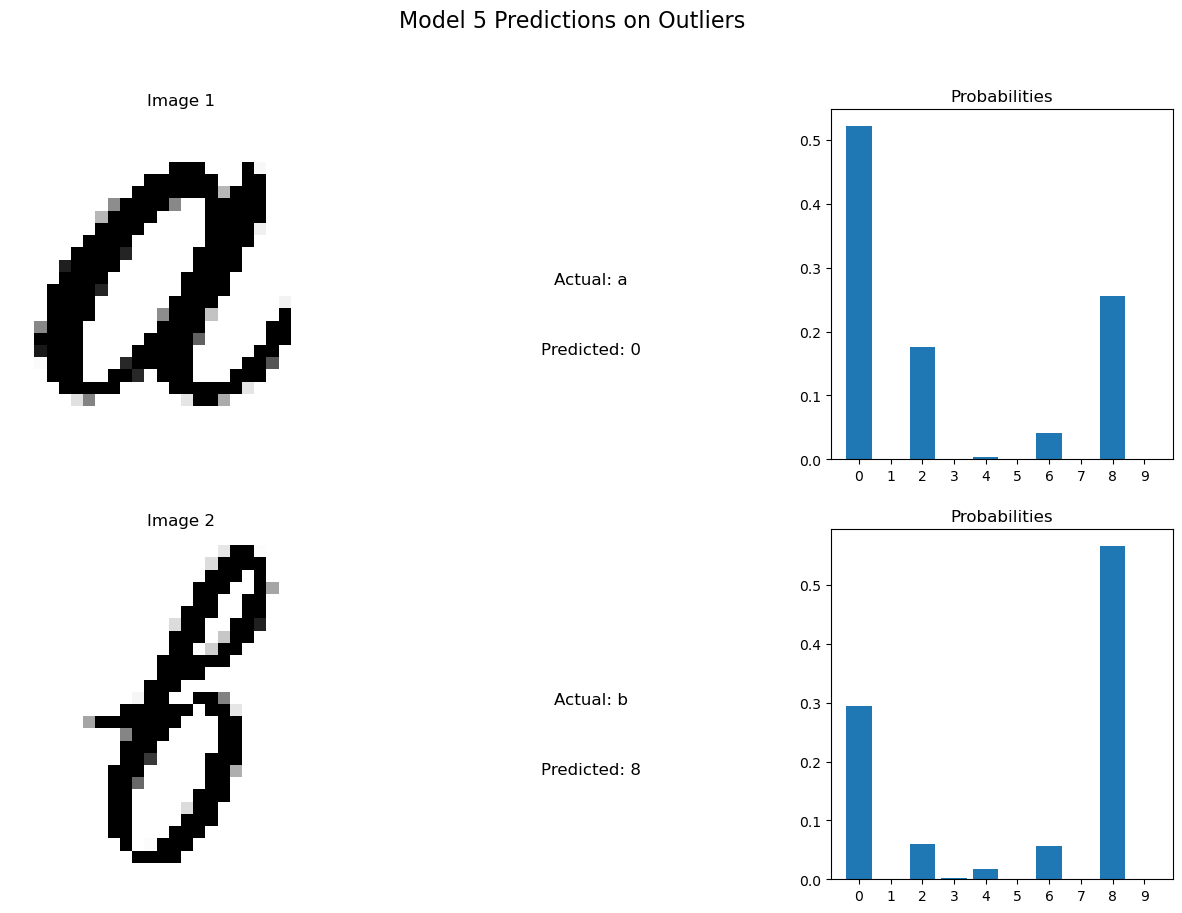

Model 6:


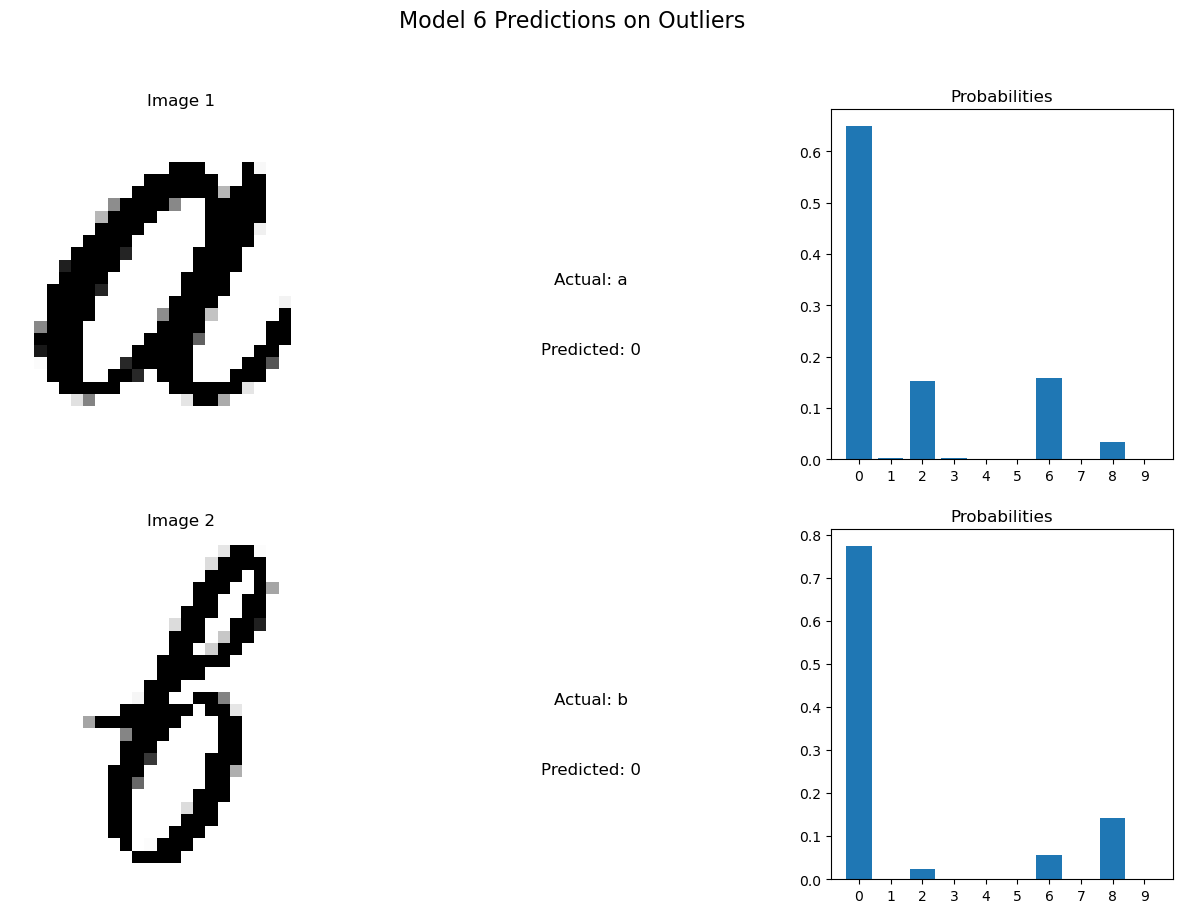

Model 7:


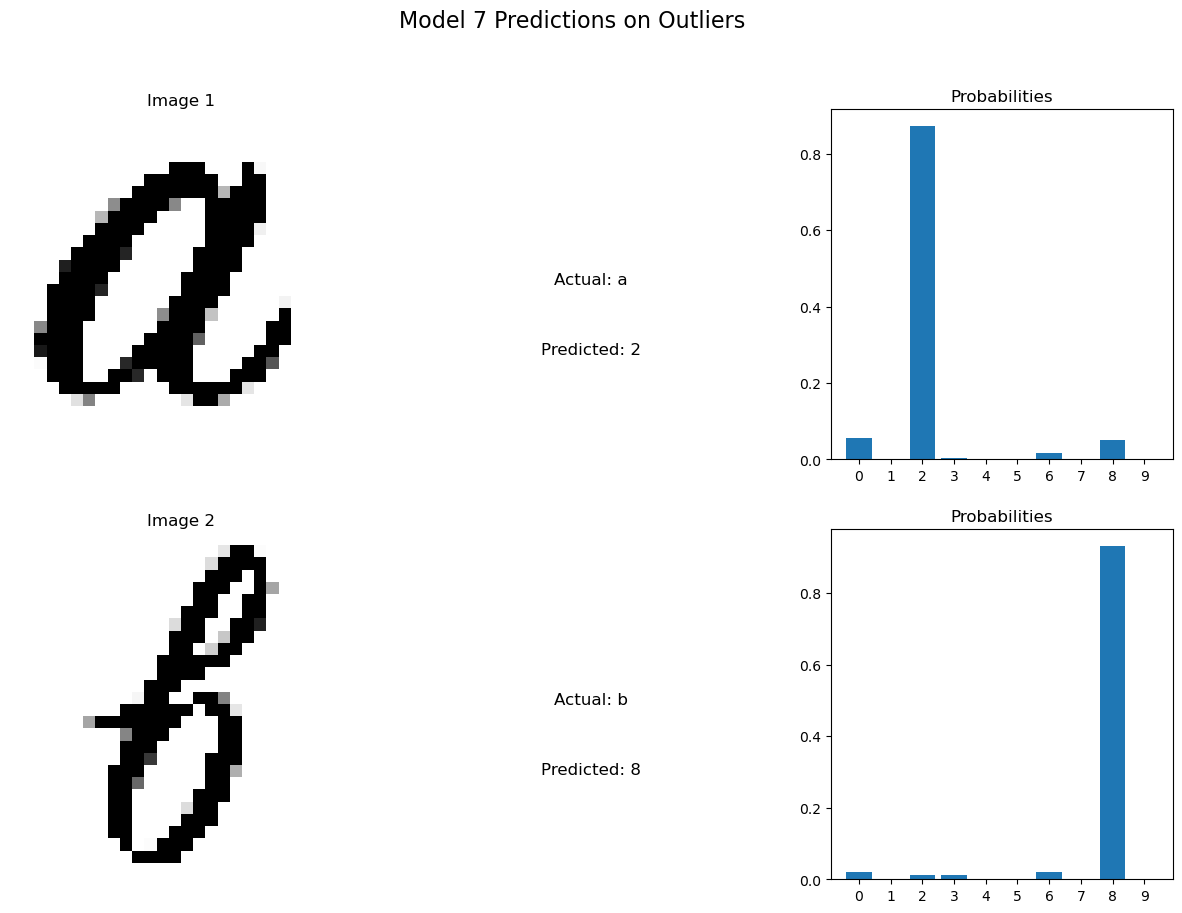

Outlier Test Results:
    Model    Image Actual Label  Predicted Label  \
0       0  Image_1            a                2   
1       0  Image_2            b                8   
2       1  Image_1            a                3   
3       1  Image_2            b                8   
4       2  Image_1            a                0   
5       2  Image_2            b                8   
6       3  Image_1            a                2   
7       3  Image_2            b                0   
8       4  Image_1            a                0   
9       4  Image_2            b                0   
10      5  Image_1            a                0   
11      5  Image_2            b                8   
12      6  Image_1            a                0   
13      6  Image_2            b                0   
14      7  Image_1            a                2   
15      7  Image_2            b                8   

                                  Class Probabilities  
0   [0.2786459, 0.0019759743, 0.60481

,Model,Image,Actual Label,Predicted Label,Class Probabilities
0,0,Image_1,a,2,"[0.2786459, 0.0019759743, 0.60481805, 0.001852..."
1,0,Image_2,b,8,"[0.32591814, 0.0011750564, 0.05909141, 0.00260..."
2,1,Image_1,a,3,"[0.00943888, 2.8617762e-06, 0.064931355, 0.539..."
3,1,Image_2,b,8,"[0.026219483, 3.541752e-06, 0.040122535, 0.256..."
4,2,Image_1,a,0,"[0.44509932, 0.0016680212, 0.2850628, 0.001925..."
5,2,Image_2,b,8,"[0.3315615, 0.02841612, 0.11622366, 0.00441844..."
6,3,Image_1,a,2,"[0.17326012, 0.02501619, 0.71670306, 0.0019412..."
7,3,Image_2,b,0,"[0.417464, 0.076042876, 0.21839677, 0.00425980..."
8,4,Image_1,a,0,"[0.85478634, 0.033470057, 0.0008418106, 2.5836..."
9,4,Image_2,b,0,"[0.639019, 0.083592184, 0.0012040947, 0.000489..."


In [18]:
visualize_outlier_examples(outlier_file_paths, 10)

# List of saved model paths
model_paths = [f'Model_{i}.h5' for i in range(8)]  # Adjust if you have a different number of models

# Load trained models
models = load_trained_models(model_paths)


# Visualize predictions for outliers
visualize_outliers(models, outlier_file_paths, outlier_labels, num_samples=2)


## Train and Evaluate with standard models, Compare with earlier results

1. Lenet
2. Resnet50
3. Densenet121

Training LeNet model
Epoch 1/5
29/29 [==============================] - 7s 145ms/step - loss: 2.1462 - accuracy: 0.3500 - val_loss: 0.9588 - val_accuracy: 0.7800
Epoch 2/5
29/29 [==============================] - 0s 5ms/step - loss: 0.7672 - accuracy: 0.7962 - val_loss: 0.3877 - val_accuracy: 0.8717
Epoch 3/5
29/29 [==============================] - 0s 5ms/step - loss: 0.4254 - accuracy: 0.8662 - val_loss: 0.2775 - val_accuracy: 0.9242
Epoch 4/5
29/29 [==============================] - 0s 5ms/step - loss: 0.3071 - accuracy: 0.9104 - val_loss: 0.2305 - val_accuracy: 0.9350
Epoch 5/5
38/38 [==============================] - 1s 2ms/step - loss: 0.2437 - accuracy: 0.9292
Model saved to temp_model.h5


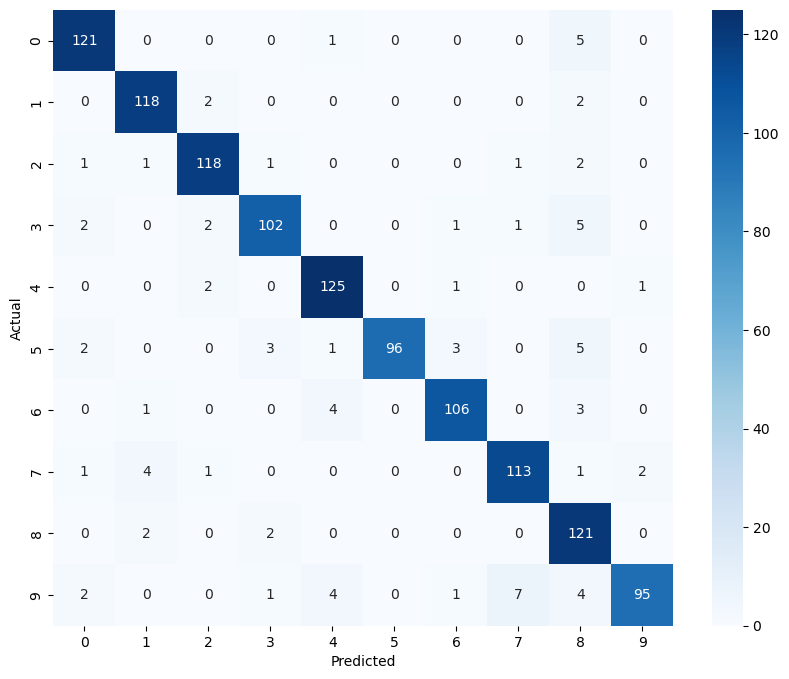

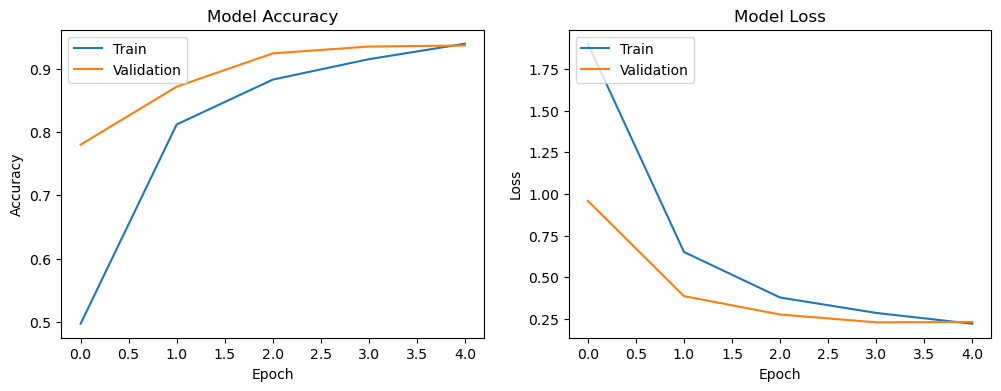

Training ResNet50 model
Epoch 1/5
29/29 [==============================] - 32s 715ms/step - loss: 2.6975 - accuracy: 0.2836 - val_loss: 1.2258 - val_accuracy: 0.6125
Epoch 2/5
29/29 [==============================] - 0s 16ms/step - loss: 1.1262 - accuracy: 0.6543 - val_loss: 0.9953 - val_accuracy: 0.6625
Epoch 3/5
29/29 [==============================] - 0s 16ms/step - loss: 0.8663 - accuracy: 0.7206 - val_loss: 0.6793 - val_accuracy: 0.8108
Epoch 4/5
29/29 [==============================] - 0s 16ms/step - loss: 0.6564 - accuracy: 0.8119 - val_loss: 0.6760 - val_accuracy: 0.7783
Epoch 5/5
38/38 [==============================] - 10s 8ms/step - loss: 0.5694 - accuracy: 0.8350
Model saved to temp_model.h5


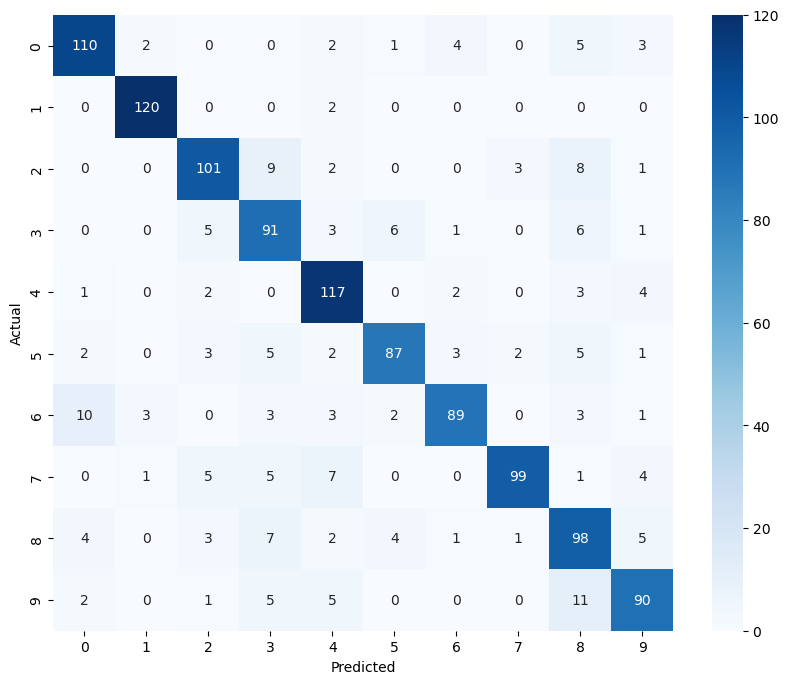

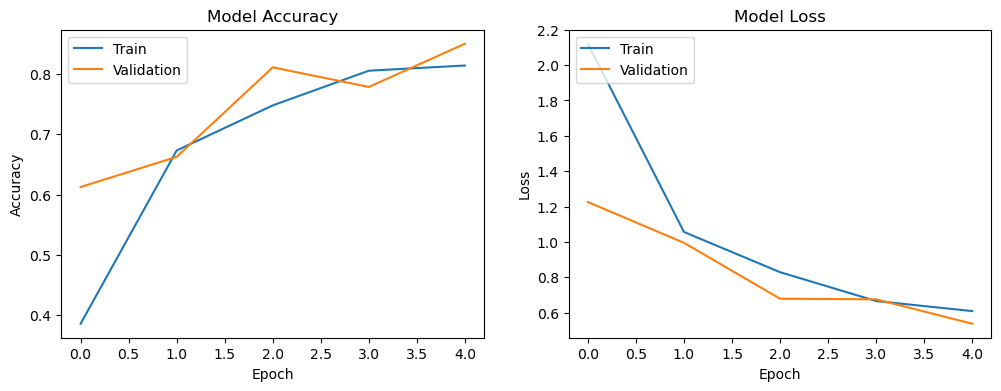

Training DenseNet121 model
Epoch 1/5
29/29 [==============================] - 112s 3s/step - loss: 1.6157 - accuracy: 0.5040 - val_loss: 0.5288 - val_accuracy: 0.8325
Epoch 2/5
29/29 [==============================] - 1s 18ms/step - loss: 0.4660 - accuracy: 0.8494 - val_loss: 0.3487 - val_accuracy: 0.8967
Epoch 3/5
29/29 [==============================] - 1s 18ms/step - loss: 0.3058 - accuracy: 0.9047 - val_loss: 0.2935 - val_accuracy: 0.9125
Epoch 4/5
29/29 [==============================] - 1s 18ms/step - loss: 0.2419 - accuracy: 0.9251 - val_loss: 0.2644 - val_accuracy: 0.9217
Epoch 5/5
38/38 [==============================] - 36s 11ms/step - loss: 0.2623 - accuracy: 0.9183
Model saved to temp_model.h5


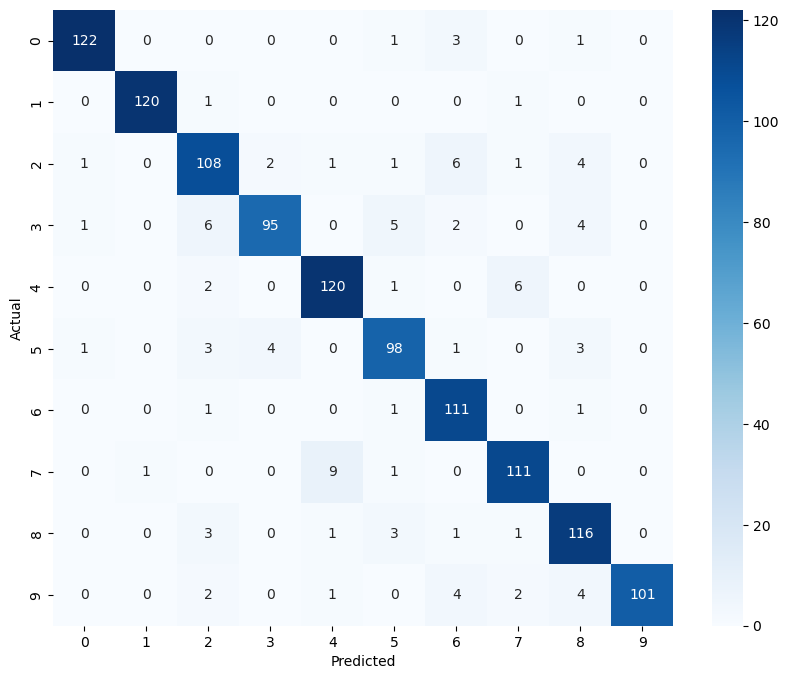

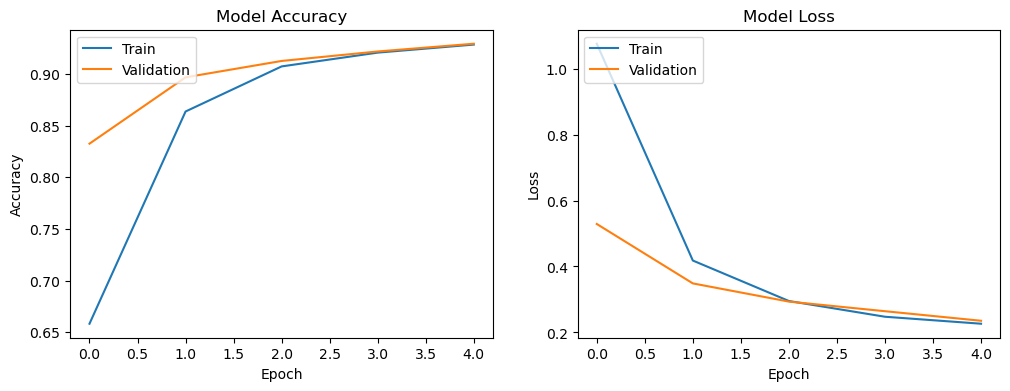

         Model  Training Time (s)  Training Accuracy (%)  \
0        LeNet           7.611944              93.944442   
1     ResNet50          33.813018              81.388891   
2  DenseNet121         113.872312              92.833334   

   Validation Accuracy (%)  Testing Time (s)  Testing Accuracy (%)  \
0                93.666667          1.267965             92.916667   
1                85.000002          9.604727             83.499998   
2                92.916667         35.610006             91.833335   

   Model Size (MB)  
0         0.554039  
1       114.607162  
2        40.080521  


In [19]:
std_results = train_and_evaluate_standard_models()
print(std_results)

In [20]:
# Example columns for consistency
common_columns = [
    'Model', 'Training Time (s)', 'Training Accuracy (%)', 'Validation Accuracy (%)',
    'Testing Time (s)', 'Testing Accuracy (%)', 'Model Size (MB)'
]

df_results = df_results[common_columns]
std_results = std_results[common_columns]

# Ensure consistent columns and add a source identifier
df_results = df_results[common_columns].copy()
df_results['Source'] = 'Custom'

std_results = std_results[common_columns].copy()
std_results['Source'] = 'Standard'

# Concatenate DataFrames
comparison_df = pd.concat([df_results, std_results], ignore_index=True)

# Display comparison results
print(comparison_df.to_markdown(index=False))

| Model       |   Training Time (s) |   Training Accuracy (%) |   Validation Accuracy (%) |   Testing Time (s) |   Testing Accuracy (%) |   Model Size (MB) | Source   |
|:------------|--------------------:|------------------------:|--------------------------:|-------------------:|-----------------------:|------------------:|:---------|
| 1           |            13.5775  |                 95.8611 |                   96.4167 |           1.96826  |                95.8333 |          2.81599  | Custom   |
| 2           |            27.011   |                 88.1944 |                   92      |           0.105424 |                90.0833 |          0.953392 | Custom   |
| 3           |             1.36816 |                 93.9444 |                   95.75   |           0.105299 |                94.4167 |          2.81612  | Custom   |
| 4           |            12.407   |                 96.7778 |                   96.8333 |           2.06804  |                96.25   |          7.67359 

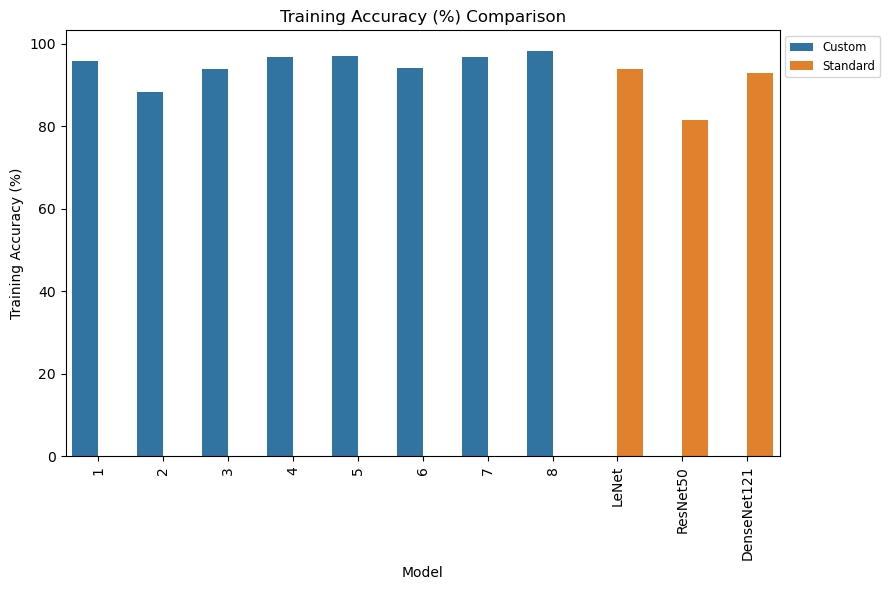

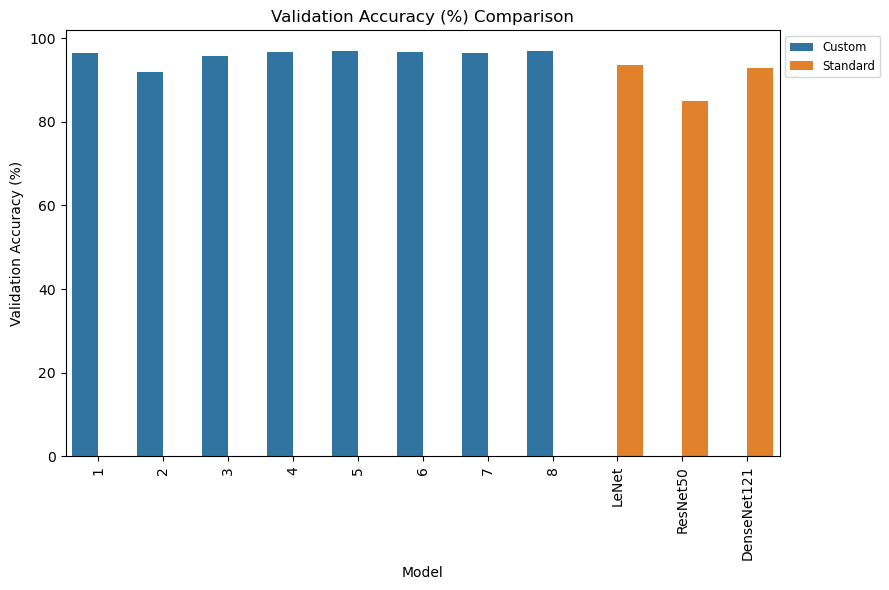

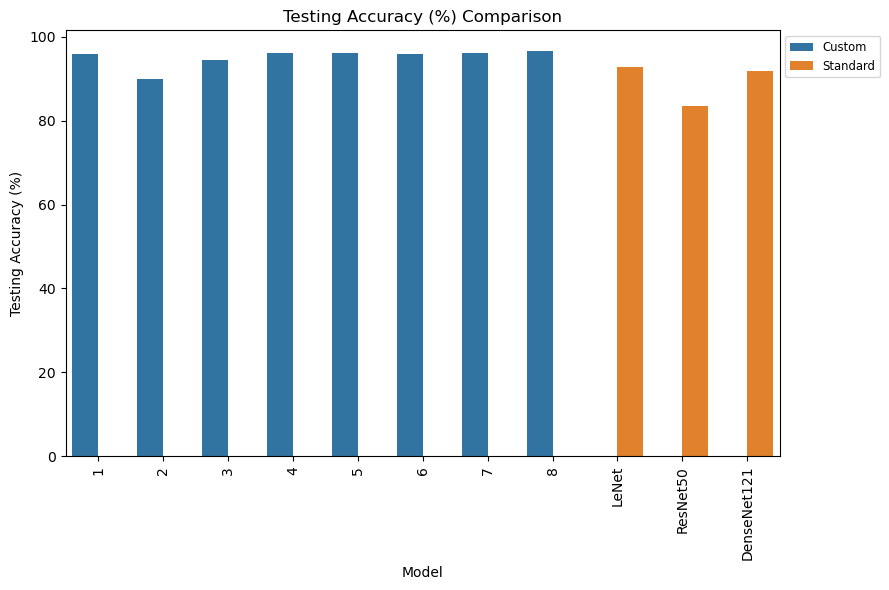

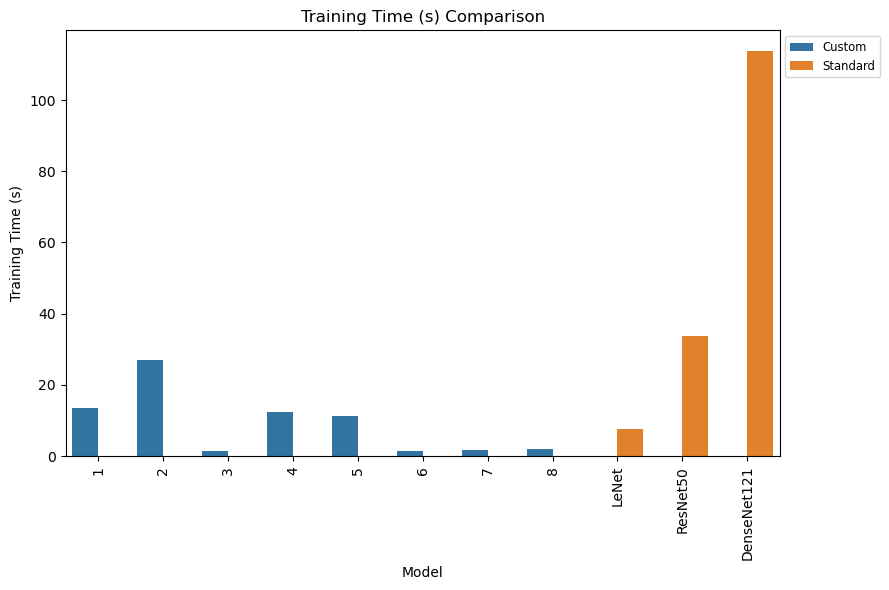

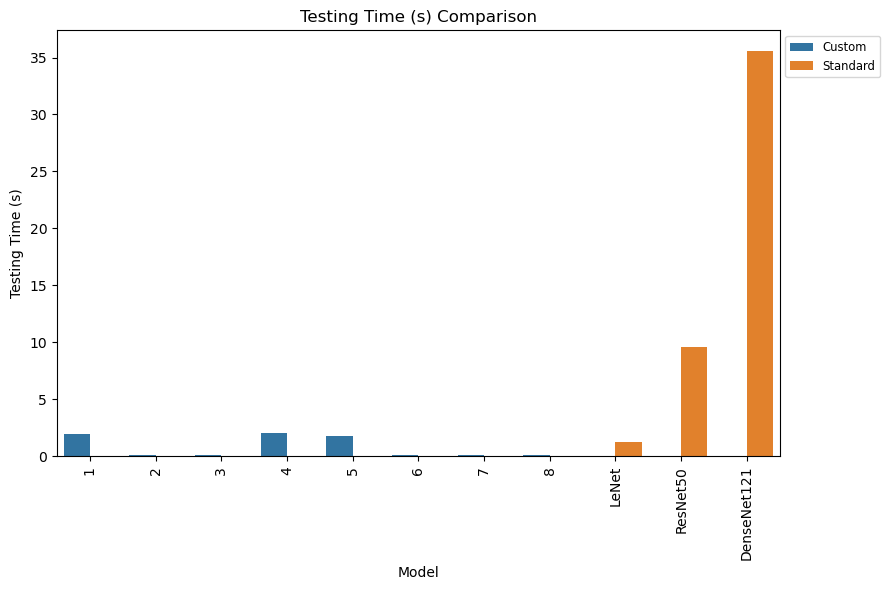

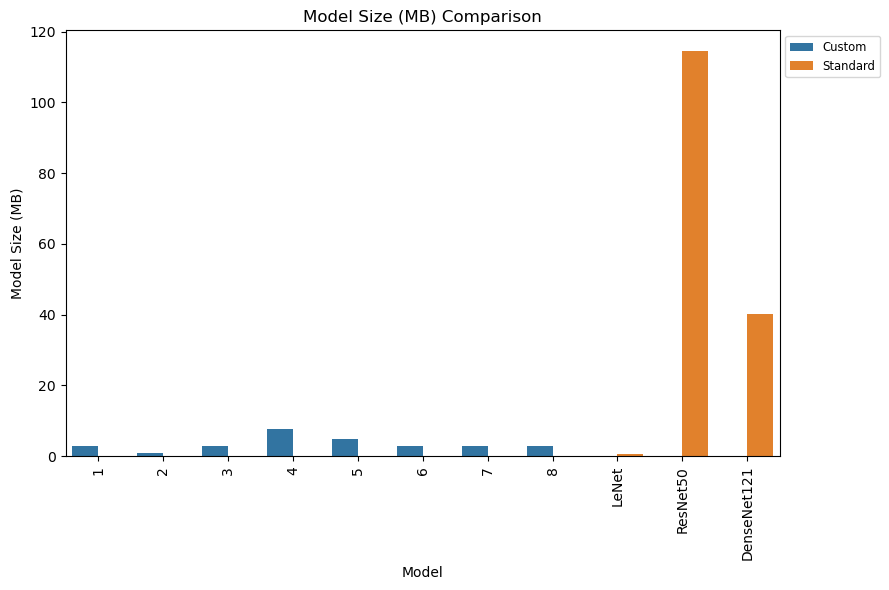

In [21]:
visualize_comparison_stats(comparison_df)

## Printing MODELS!!

In [ ]:
from tensorflow.keras.utils import plot_model

def plot_models_new(models_range):
    # Ensure that models_range is iterable
    if isinstance(models_range, int):
        models_range = range(models_range)  # Convert to range if an integer is passed
    
    for i in models_range:
        # Load the model
        model_filename = f'Model_{i}.h5'
        try:
            loaded_model = load_model(model_filename)
            print(f"Visualizing predictions for {model_filename}...")
            
            # Display the model architecture
            loaded_model.summary()  
            
            # Optionally save the model architecture as a PNG file
            plot_model(loaded_model, to_file=f'{model_filename}_architecture.png', show_shapes=True) 
        except Exception as e:
            print(f"Failed to load or visualize {model_filename}. Error: {e}")

plot_models_new(8)

loaded_model = load_model('Model_LeNet.h5')
loaded_model.summary()  
# Optionally save the model architecture as a PNG file
plot_model(loaded_model, to_file=f'LeNet_architecture.png', show_shapes=True) 


loaded_model = load_model('Model_ResNet50.h5')
loaded_model.summary()  
# Optionally save the model architecture as a PNG file
plot_model(loaded_model, to_file=f'ResNet50_architecture.png', show_shapes=True) 

loaded_model = load_model('Model_DenseNet121.h5')
loaded_model.summary()  
# Optionally save the model architecture as a PNG file
plot_model(loaded_model, to_file=f'DenseNet121_architecture.png', show_shapes=True) 